# GAN 

속이려는 애(가짜 데이터)와 진짜 데이터를 비교해서 성능을 높여간다. 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

In [4]:
# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

- 오버피팅에 좀 둔감하다. 

In [5]:
def load_minst_data():
    # 데이터를 로드합니다.
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # 데이터를 -1 ~ 1 사이 값으로 normalize 합니다.
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    # x_train 의 shape 를 (60000, 28, 28) 에서 (60000, 784) 로 바꿉니다.
    # 따라서 우리는 한 row 당 784 columns 을 가지게 됩니다.
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [6]:
# Adam Optimizer를 사용합니다.
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

- autoencoder랑 비슷하다. 

- train on batch

In [7]:
# Generator 만들기
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [8]:
# Discriminator 만들기
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [9]:
def get_gan_network(discriminator, random_dim, generator, optimizer):

    discriminator.trainable = False
    # GAN 입력 (노이즈)은 위에서 100 차원으로 설정했습니다.
    gan_input = Input(shape=(random_dim,))

    # Generator의 결과는 이미지 입니다.
    x = generator(gan_input)

    # Discriminator의 결과는 이미지가 진짜인지 가짜인지에 대한 확률입니다.
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [10]:
# 생성된 MNIST 이미지를 보여주는 함수
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batch_size=128):
    # train 데이터와 test 데이터를 가져옵니다.
    x_train, y_train, x_test, y_test = load_minst_data()

    # train 데이터를 128 사이즈의 batch 로 나눕니다.
    batch_count = x_train.shape[0] // batch_size

    # 우리의 GAN 네트워크를 만듭니다.
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # MNIST 이미지를 생성합니다.
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            # Discriminator를 학습시킵니다.
            discriminator.trainable = True
            discriminator.fit(X, y_dis)
#           train_on_batch하면 batch마다 보여주기 때문에 더 정교하다. 
#           학습이 잘 안되는 경우 train_on_batch를 쓰면 더 좋다. 
#           하지만 train_on_batch는 callback이 없다. 그렇지만 callback을 상속시키면 불러올 수 있다. 
#           fit도 쓸 수 있다. 
#           loss function이 기본으로 안 정해져있는 경우 gradient_tape을 써야한다. 

            # Generator를 학습시킵니다.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.fit(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)


In [25]:
import tensorflow as tf 

In [34]:
from tensorflow.keras.callbacks import Callback

In [36]:
class history(tf.keras.callbacks.Callback):
    def on_batch_begin():
        self.loss=[]

In [32]:
Callback.on_batch_begin
Callback.on_train_begin
# fit 써야지고 더 상세하게 

<function tensorflow.python.keras.callbacks.Callback.on_train_begin(self, logs=None)>

In [26]:
tf.debugging.set_log_device_placement=True

--------------- Epoch 1 ---------------





  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Train on 256 samples
256/256 [==============================] - ETA: 4s - loss: 0.749 - ETA: 2s - loss: 0.625 - ETA: 1s - loss: 0.594 - ETA: 0s - loss: 0.571 - ETA: 0s - loss: 0.557 - ETA: 0s - loss: 0.544 - ETA: 0s - loss: 0.539 - 1s 5ms/sample - loss: 0.5340
Train on 128 samples
128/128 [==============================] - ETA: 3s - loss: 0.805 - ETA: 1s - loss: 0.781 - ETA: 0s - loss: 0.758 - 2s 13ms/sample - loss: 0.7385





  0%|▏                                                                                 | 1/468 [00:03<25:25,  3.27s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.586 - ETA: 0s - loss: 0.560 - ETA: 0s - loss: 0.546 - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.527 - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.518 - 1s 3ms/sample - loss: 0.5114
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 0.816 - ETA: 0s - loss: 0.790 - ETA: 0s - loss: 0.761 - 1s 5ms/sample - loss: 0.7407





  0%|▎                                                                                 | 2/468 [00:04<21:31,  2.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.562 - ETA: 0s - loss: 0.551 - ETA: 0s - loss: 0.530 - ETA: 0s - loss: 0.518 - ETA: 0s - loss: 0.513 - ETA: 0s - loss: 0.503 - 1s 3ms/sample - loss: 0.4951
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.004 - ETA: 0s - loss: 0.932 - ETA: 0s - loss: 0.871 - 1s 4ms/sample - loss: 0.8237





  1%|▌                                                                                 | 3/468 [00:06<18:36,  2.40s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.543 - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.511 - ETA: 0s - loss: 0.502 - 1s 3ms/sample - loss: 0.4900
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.112 - ETA: 0s - loss: 1.037 - ETA: 0s - loss: 0.956 - 1s 5ms/sample - loss: 0.8905





  1%|▋                                                                                 | 4/468 [00:08<17:08,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.534 - ETA: 0s - loss: 0.545 - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.528 - ETA: 0s - loss: 0.531 - ETA: 0s - loss: 0.518 - ETA: 0s - loss: 0.511 - 1s 3ms/sample - loss: 0.5025
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.037 - ETA: 0s - loss: 0.976 - ETA: 0s - loss: 0.912 - 1s 5ms/sample - loss: 0.8548





  1%|▉                                                                                 | 5/468 [00:09<15:34,  2.02s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.631 - ETA: 0s - loss: 0.640 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.602 - ETA: 0s - loss: 0.585 - ETA: 0s - loss: 0.565 - ETA: 0s - loss: 0.555 - 1s 3ms/sample - loss: 0.5405
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 0.994 - ETA: 0s - loss: 0.933 - ETA: 0s - loss: 0.875 - 1s 5ms/sample - loss: 0.8204





  1%|█                                                                                 | 6/468 [00:11<14:24,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.504 - ETA: 0s - loss: 0.580 - ETA: 0s - loss: 0.574 - ETA: 0s - loss: 0.567 - ETA: 0s - loss: 0.557 - ETA: 0s - loss: 0.548 - ETA: 0s - loss: 0.538 - 1s 3ms/sample - loss: 0.5219
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.074 - ETA: 0s - loss: 0.956 - ETA: 0s - loss: 0.855 - 1s 5ms/sample - loss: 0.7778





  1%|█▏                                                                                | 7/468 [00:12<13:37,  1.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.670 - ETA: 0s - loss: 0.673 - ETA: 0s - loss: 0.726 - ETA: 0s - loss: 0.714 - ETA: 0s - loss: 0.691 - ETA: 0s - loss: 0.660 - ETA: 0s - loss: 0.642 - 1s 3ms/sample - loss: 0.6232
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 0.922 - ETA: 0s - loss: 0.883 - ETA: 0s - loss: 0.849 - 1s 5ms/sample - loss: 0.8061





  2%|█▍                                                                                | 8/468 [00:14<13:01,  1.70s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.547 - ETA: 0s - loss: 0.592 - ETA: 0s - loss: 0.590 - ETA: 0s - loss: 0.596 - ETA: 0s - loss: 0.578 - ETA: 0s - loss: 0.579 - ETA: 0s - loss: 0.562 - 1s 3ms/sample - loss: 0.5474
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 0.894 - ETA: 0s - loss: 0.771 - ETA: 0s - loss: 0.673 - 1s 4ms/sample - loss: 0.5893





  2%|█▌                                                                                | 9/468 [00:15<12:36,  1.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.907 - ETA: 0s - loss: 0.823 - ETA: 0s - loss: 0.787 - ETA: 0s - loss: 0.734 - ETA: 0s - loss: 0.696 - ETA: 0s - loss: 0.663 - ETA: 0s - loss: 0.632 - 1s 3ms/sample - loss: 0.6142
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 0.841 - ETA: 0s - loss: 0.701 - ETA: 0s - loss: 0.587 - 1s 5ms/sample - loss: 0.4967





  2%|█▋                                                                               | 10/468 [00:17<12:35,  1.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 1.113 - ETA: 0s - loss: 0.884 - ETA: 0s - loss: 0.855 - ETA: 0s - loss: 0.798 - ETA: 0s - loss: 0.776 - ETA: 0s - loss: 0.736 - ETA: 0s - loss: 0.725 - 1s 3ms/sample - loss: 0.7020
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 0.793 - ETA: 0s - loss: 0.682 - ETA: 0s - loss: 0.589 - 1s 6ms/sample - loss: 0.5114





  2%|█▉                                                                               | 11/468 [00:19<13:08,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.985 - ETA: 0s - loss: 0.870 - ETA: 0s - loss: 0.817 - ETA: 0s - loss: 0.783 - ETA: 0s - loss: 0.747 - ETA: 0s - loss: 0.716 - ETA: 0s - loss: 0.694 - 1s 3ms/sample - loss: 0.6610
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.588 - ETA: 0s - loss: 1.394 - ETA: 0s - loss: 1.212 - 1s 5ms/sample - loss: 1.0268





  3%|██                                                                               | 12/468 [00:20<12:36,  1.66s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.829 - ETA: 0s - loss: 0.801 - ETA: 0s - loss: 0.781 - ETA: 0s - loss: 0.740 - ETA: 0s - loss: 0.702 - ETA: 0s - loss: 0.676 - ETA: 0s - loss: 0.648 - 1s 3ms/sample - loss: 0.6160
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.997 - ETA: 0s - loss: 1.750 - ETA: 0s - loss: 1.495 - 1s 6ms/sample - loss: 1.2635





  3%|██▎                                                                              | 13/468 [00:22<12:50,  1.69s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.981 - ETA: 0s - loss: 0.913 - ETA: 0s - loss: 0.846 - ETA: 0s - loss: 0.797 - ETA: 0s - loss: 0.745 - ETA: 0s - loss: 0.702 - ETA: 0s - loss: 0.660 - 1s 3ms/sample - loss: 0.6229
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.877 - ETA: 0s - loss: 1.636 - ETA: 0s - loss: 1.319 - 1s 5ms/sample - loss: 1.0804





  3%|██▍                                                                              | 14/468 [00:24<12:33,  1.66s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 1.189 - ETA: 0s - loss: 1.149 - ETA: 0s - loss: 1.015 - ETA: 0s - loss: 0.889 - ETA: 0s - loss: 0.831 - ETA: 0s - loss: 0.774 - ETA: 0s - loss: 0.741 - 1s 3ms/sample - loss: 0.6970
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.111 - ETA: 0s - loss: 0.970 - ETA: 0s - loss: 0.837 - 1s 5ms/sample - loss: 0.7253





  3%|██▌                                                                              | 15/468 [00:25<12:31,  1.66s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 1.004 - ETA: 0s - loss: 0.863 - ETA: 0s - loss: 0.764 - ETA: 0s - loss: 0.686 - ETA: 0s - loss: 0.659 - ETA: 0s - loss: 0.619 - ETA: 0s - loss: 0.579 - 1s 3ms/sample - loss: 0.5532
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.669 - ETA: 0s - loss: 1.331 - ETA: 0s - loss: 1.037 - 1s 5ms/sample - loss: 0.8486





  3%|██▊                                                                              | 16/468 [00:27<12:24,  1.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 1.068 - ETA: 0s - loss: 0.943 - ETA: 0s - loss: 0.850 - ETA: 0s - loss: 0.785 - ETA: 0s - loss: 0.729 - ETA: 0s - loss: 0.685 - ETA: 0s - loss: 0.643 - 1s 4ms/sample - loss: 0.6091
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.864 - ETA: 0s - loss: 1.721 - ETA: 0s - loss: 1.446 - 1s 5ms/sample - loss: 1.2181





  4%|██▉                                                                              | 17/468 [00:29<13:05,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 1.015 - ETA: 0s - loss: 0.899 - ETA: 0s - loss: 0.842 - ETA: 0s - loss: 0.743 - ETA: 0s - loss: 0.725 - ETA: 0s - loss: 0.681 - ETA: 0s - loss: 0.659 - 1s 3ms/sample - loss: 0.6312
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.539 - ETA: 0s - loss: 1.384 - ETA: 0s - loss: 1.213 - 1s 5ms/sample - loss: 1.0604





  4%|███                                                                              | 18/468 [00:31<12:56,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.696 - ETA: 0s - loss: 0.674 - ETA: 0s - loss: 0.644 - ETA: 0s - loss: 0.635 - ETA: 0s - loss: 0.603 - ETA: 0s - loss: 0.583 - ETA: 0s - loss: 0.559 - 1s 3ms/sample - loss: 0.5398
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.605 - ETA: 0s - loss: 1.439 - ETA: 0s - loss: 1.267 - 1s 7ms/sample - loss: 1.1069





  4%|███▎                                                                             | 19/468 [00:33<13:27,  1.80s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.695 - ETA: 1s - loss: 0.685 - ETA: 0s - loss: 0.656 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.590 - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.528 - 1s 5ms/sample - loss: 0.5019
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.678 - ETA: 0s - loss: 1.548 - ETA: 0s - loss: 1.306 - 1s 5ms/sample - loss: 1.1136





  4%|███▍                                                                             | 20/468 [00:35<14:12,  1.90s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.858 - ETA: 0s - loss: 0.784 - ETA: 0s - loss: 0.729 - ETA: 0s - loss: 0.669 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.582 - ETA: 0s - loss: 0.552 - 1s 3ms/sample - loss: 0.5359
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.869 - ETA: 0s - loss: 1.703 - ETA: 0s - loss: 1.520 - 1s 5ms/sample - loss: 1.3333





  4%|███▋                                                                             | 21/468 [00:36<13:27,  1.81s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.592 - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.537 - ETA: 0s - loss: 0.505 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.449 - ETA: 0s - loss: 0.427 - 1s 4ms/sample - loss: 0.4049
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.132 - ETA: 0s - loss: 1.843 - ETA: 0s - loss: 1.547 - 1s 5ms/sample - loss: 1.2993





  5%|███▊                                                                             | 22/468 [00:38<13:43,  1.85s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.833 - ETA: 0s - loss: 0.743 - ETA: 0s - loss: 0.700 - ETA: 0s - loss: 0.632 - ETA: 0s - loss: 0.586 - ETA: 0s - loss: 0.545 - ETA: 0s - loss: 0.515 - 1s 3ms/sample - loss: 0.4859
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.085 - ETA: 0s - loss: 1.783 - ETA: 0s - loss: 1.510 - 1s 5ms/sample - loss: 1.2783





  5%|███▉                                                                             | 23/468 [00:40<12:56,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.663 - ETA: 0s - loss: 0.665 - ETA: 0s - loss: 0.616 - ETA: 0s - loss: 0.565 - ETA: 0s - loss: 0.528 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.470 - 1s 3ms/sample - loss: 0.4465
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.178 - ETA: 0s - loss: 1.955 - ETA: 0s - loss: 1.730 - 1s 5ms/sample - loss: 1.5354





  5%|████▏                                                                            | 24/468 [00:41<12:26,  1.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.605 - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.544 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.557 - ETA: 0s - loss: 0.530 - ETA: 0s - loss: 0.516 - 1s 3ms/sample - loss: 0.4990
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.157 - ETA: 0s - loss: 1.074 - ETA: 0s - loss: 0.983 - 1s 5ms/sample - loss: 0.9061





  5%|████▎                                                                            | 25/468 [00:43<12:01,  1.63s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.681 - ETA: 0s - loss: 0.587 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.514 - ETA: 0s - loss: 0.493 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.453 - 1s 3ms/sample - loss: 0.4431
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.319 - ETA: 0s - loss: 1.210 - ETA: 0s - loss: 1.067 - 1s 5ms/sample - loss: 0.9469





  6%|████▌                                                                            | 26/468 [00:44<11:49,  1.60s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.666 - ETA: 0s - loss: 0.563 - ETA: 0s - loss: 0.631 - ETA: 0s - loss: 0.621 - ETA: 0s - loss: 0.586 - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.532 - 1s 3ms/sample - loss: 0.5111
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.578 - ETA: 0s - loss: 1.412 - ETA: 0s - loss: 1.257 - 1s 5ms/sample - loss: 1.0955





  6%|████▋                                                                            | 27/468 [00:46<11:36,  1.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.630 - ETA: 0s - loss: 0.586 - ETA: 0s - loss: 0.567 - ETA: 0s - loss: 0.544 - ETA: 0s - loss: 0.543 - ETA: 0s - loss: 0.523 - ETA: 0s - loss: 0.496 - 1s 3ms/sample - loss: 0.4793
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.405 - ETA: 0s - loss: 1.260 - ETA: 0s - loss: 1.088 - 1s 5ms/sample - loss: 0.9396





  6%|████▊                                                                            | 28/468 [00:48<11:50,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.882 - ETA: 0s - loss: 0.769 - ETA: 0s - loss: 0.657 - ETA: 0s - loss: 0.588 - ETA: 0s - loss: 0.537 - ETA: 0s - loss: 0.504 - ETA: 0s - loss: 0.475 - 1s 4ms/sample - loss: 0.4492
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.500 - ETA: 0s - loss: 2.311 - ETA: 0s - loss: 2.094 - 1s 5ms/sample - loss: 1.8473





  6%|█████                                                                            | 29/468 [00:49<12:05,  1.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.593 - ETA: 0s - loss: 0.563 - ETA: 0s - loss: 0.494 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.418 - 1s 3ms/sample - loss: 0.3997
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.595 - ETA: 0s - loss: 2.379 - ETA: 0s - loss: 2.207 - 1s 5ms/sample - loss: 2.0068





  6%|█████▏                                                                           | 30/468 [00:51<11:44,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.369 - 1s 3ms/sample - loss: 0.3599
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.237 - ETA: 0s - loss: 2.048 - ETA: 0s - loss: 1.865 - 1s 5ms/sample - loss: 1.6661





  7%|█████▎                                                                           | 31/468 [00:53<11:45,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.501 - ETA: 0s - loss: 0.496 - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.380 - 1s 4ms/sample - loss: 0.3669
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.117 - ETA: 0s - loss: 1.975 - ETA: 0s - loss: 1.789 - 1s 5ms/sample - loss: 1.5976





  7%|█████▌                                                                           | 32/468 [00:54<12:23,  1.71s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.313 - 1s 3ms/sample - loss: 0.3021
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.394 - ETA: 0s - loss: 2.760 - ETA: 0s - loss: 2.281 - 1s 5ms/sample - loss: 1.9852





  7%|█████▋                                                                           | 33/468 [00:56<11:57,  1.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.352 - 1s 3ms/sample - loss: 0.3529
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.424 - ETA: 0s - loss: 1.259 - ETA: 0s - loss: 1.102 - 1s 5ms/sample - loss: 0.9505





  7%|█████▉                                                                           | 34/468 [00:57<11:37,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.966 - ETA: 0s - loss: 0.676 - ETA: 0s - loss: 0.625 - ETA: 0s - loss: 0.564 - ETA: 0s - loss: 0.523 - ETA: 0s - loss: 0.484 - ETA: 0s - loss: 0.465 - 1s 3ms/sample - loss: 0.4504
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.632 - ETA: 0s - loss: 1.562 - ETA: 0s - loss: 1.411 - 1s 5ms/sample - loss: 1.2338





  7%|██████                                                                           | 35/468 [00:59<11:22,  1.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.680 - ETA: 0s - loss: 0.585 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.404 - 1s 3ms/sample - loss: 0.3862
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.138 - ETA: 0s - loss: 1.903 - ETA: 0s - loss: 1.654 - 1s 5ms/sample - loss: 1.3915





  8%|██████▏                                                                          | 36/468 [01:01<11:16,  1.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.787 - ETA: 0s - loss: 0.689 - ETA: 0s - loss: 0.593 - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.457 - 1s 3ms/sample - loss: 0.4381
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.941 - ETA: 0s - loss: 2.730 - ETA: 0s - loss: 2.476 - 1s 5ms/sample - loss: 2.1721





  8%|██████▍                                                                          | 37/468 [01:02<11:16,  1.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.506 - ETA: 0s - loss: 0.493 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.437 - 1s 4ms/sample - loss: 0.4224
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.441 - ETA: 0s - loss: 2.253 - ETA: 0s - loss: 2.103 - 1s 7ms/sample - loss: 1.9226





  8%|██████▌                                                                          | 38/468 [01:04<12:16,  1.71s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.466 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.381 - 1s 3ms/sample - loss: 0.3699
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.919 - ETA: 0s - loss: 1.730 - ETA: 0s - loss: 1.521 - 1s 5ms/sample - loss: 1.2998





  8%|██████▊                                                                          | 39/468 [01:06<12:00,  1.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.634 - ETA: 0s - loss: 0.578 - ETA: 0s - loss: 0.500 - ETA: 0s - loss: 0.442 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.377 - 1s 3ms/sample - loss: 0.3544
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.525 - ETA: 0s - loss: 3.225 - ETA: 0s - loss: 2.880 - 1s 5ms/sample - loss: 2.5275





  9%|██████▉                                                                          | 40/468 [01:07<11:38,  1.63s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.612 - ETA: 0s - loss: 0.592 - ETA: 0s - loss: 0.527 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.446 - 1s 3ms/sample - loss: 0.4227
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.804 - ETA: 0s - loss: 2.711 - ETA: 0s - loss: 2.472 - 1s 5ms/sample - loss: 2.2285





  9%|███████                                                                          | 41/468 [01:09<11:33,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.502 - ETA: 0s - loss: 0.580 - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.495 - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.419 - 1s 3ms/sample - loss: 0.4059
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.190 - ETA: 0s - loss: 1.979 - ETA: 0s - loss: 1.765 - 1s 5ms/sample - loss: 1.5442





  9%|███████▎                                                                         | 42/468 [01:10<11:16,  1.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.519 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.434 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.372 - 1s 3ms/sample - loss: 0.3533
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.371 - ETA: 0s - loss: 2.174 - ETA: 0s - loss: 1.953 - 1s 5ms/sample - loss: 1.7508





  9%|███████▍                                                                         | 43/468 [01:12<11:10,  1.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.499 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.351 - 1s 3ms/sample - loss: 0.3306
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.712 - ETA: 0s - loss: 2.443 - ETA: 0s - loss: 2.230 - 1s 5ms/sample - loss: 1.9972





  9%|███████▌                                                                         | 44/468 [01:13<11:03,  1.56s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.488 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.346 - ETA: 0s - loss: 0.337 - 1s 3ms/sample - loss: 0.3182
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.450 - ETA: 0s - loss: 3.014 - ETA: 0s - loss: 2.706 - 1s 5ms/sample - loss: 2.3384





 10%|███████▊                                                                         | 45/468 [01:15<10:56,  1.55s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.347 - 1s 3ms/sample - loss: 0.3275
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.300 - ETA: 0s - loss: 2.825 - ETA: 0s - loss: 2.409 - 1s 5ms/sample - loss: 2.0407





 10%|███████▉                                                                         | 46/468 [01:17<10:51,  1.54s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.745 - ETA: 0s - loss: 0.606 - ETA: 0s - loss: 0.527 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.434 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.387 - 1s 3ms/sample - loss: 0.3703
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.333 - ETA: 0s - loss: 2.826 - ETA: 0s - loss: 2.411 - 1s 5ms/sample - loss: 2.0774





 10%|████████▏                                                                        | 47/468 [01:18<11:02,  1.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.559 - ETA: 0s - loss: 0.497 - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.369 - 1s 3ms/sample - loss: 0.3590
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.823 - ETA: 0s - loss: 2.274 - ETA: 0s - loss: 1.856 - 1s 5ms/sample - loss: 1.5503





 10%|████████▎                                                                        | 48/468 [01:20<11:17,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.791 - ETA: 0s - loss: 0.776 - ETA: 0s - loss: 0.683 - ETA: 0s - loss: 0.630 - ETA: 0s - loss: 0.581 - ETA: 0s - loss: 0.559 - ETA: 0s - loss: 0.525 - 1s 3ms/sample - loss: 0.4954
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.532 - ETA: 0s - loss: 2.384 - ETA: 0s - loss: 2.205 - 1s 5ms/sample - loss: 2.0625





 10%|████████▍                                                                        | 49/468 [01:22<11:19,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.505 - ETA: 0s - loss: 0.484 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.394 - 1s 3ms/sample - loss: 0.3850
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.664 - ETA: 0s - loss: 2.453 - ETA: 0s - loss: 2.179 - 1s 6ms/sample - loss: 1.9237





 11%|████████▋                                                                        | 50/468 [01:23<11:22,  1.63s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.537 - ETA: 0s - loss: 0.546 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.479 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.418 - 1s 3ms/sample - loss: 0.3995
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.146 - ETA: 0s - loss: 1.877 - ETA: 0s - loss: 1.643 - 1s 5ms/sample - loss: 1.4431





 11%|████████▊                                                                        | 51/468 [01:25<11:11,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.812 - ETA: 0s - loss: 1.002 - ETA: 0s - loss: 0.847 - ETA: 0s - loss: 0.745 - ETA: 0s - loss: 0.673 - ETA: 0s - loss: 0.617 - ETA: 0s - loss: 0.584 - 1s 3ms/sample - loss: 0.5538
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.721 - ETA: 0s - loss: 1.559 - ETA: 0s - loss: 1.376 - 1s 5ms/sample - loss: 1.2129





 11%|█████████                                                                        | 52/468 [01:26<11:02,  1.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.768 - ETA: 0s - loss: 0.598 - ETA: 0s - loss: 0.540 - ETA: 0s - loss: 0.509 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.429 - 1s 3ms/sample - loss: 0.4033
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.945 - ETA: 0s - loss: 2.752 - ETA: 0s - loss: 2.556 - 1s 5ms/sample - loss: 2.3323





 11%|█████████▏                                                                       | 53/468 [01:28<10:51,  1.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.458 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.394 - 1s 3ms/sample - loss: 0.3877
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.731 - ETA: 0s - loss: 2.388 - ETA: 0s - loss: 2.138 - 1s 5ms/sample - loss: 1.9016





 12%|█████████▎                                                                       | 54/468 [01:29<10:46,  1.56s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.630 - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.497 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.369 - 1s 3ms/sample - loss: 0.3602
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.010 - ETA: 0s - loss: 2.779 - ETA: 0s - loss: 2.524 - 1s 5ms/sample - loss: 2.1903





 12%|█████████▌                                                                       | 55/468 [01:31<10:42,  1.56s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.619 - ETA: 0s - loss: 0.649 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.529 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.437 - 1s 3ms/sample - loss: 0.4166
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.422 - ETA: 0s - loss: 2.129 - ETA: 0s - loss: 1.805 - 1s 5ms/sample - loss: 1.5525





 12%|█████████▋                                                                       | 56/468 [01:32<10:41,  1.56s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.644 - ETA: 0s - loss: 0.610 - ETA: 0s - loss: 0.527 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.450 - ETA: 0s - loss: 0.434 - ETA: 0s - loss: 0.420 - 1s 3ms/sample - loss: 0.3902
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.955 - ETA: 0s - loss: 3.717 - ETA: 0s - loss: 3.345 - 1s 5ms/sample - loss: 2.8511





 12%|█████████▊                                                                       | 57/468 [01:34<11:05,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.659 - ETA: 0s - loss: 0.678 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.474 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.442 - 1s 3ms/sample - loss: 0.4327
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.751 - ETA: 0s - loss: 1.524 - ETA: 0s - loss: 1.342 - 1s 5ms/sample - loss: 1.1935





 12%|██████████                                                                       | 58/468 [01:36<11:06,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.762 - ETA: 0s - loss: 0.731 - ETA: 0s - loss: 0.652 - ETA: 0s - loss: 0.607 - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.526 - ETA: 0s - loss: 0.491 - 1s 3ms/sample - loss: 0.4801
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.619 - ETA: 0s - loss: 1.534 - ETA: 0s - loss: 1.395 - 1s 5ms/sample - loss: 1.2517





 13%|██████████▏                                                                      | 59/468 [01:37<10:57,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.667 - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.506 - ETA: 0s - loss: 0.484 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.411 - 1s 3ms/sample - loss: 0.3944
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.208 - ETA: 0s - loss: 2.002 - ETA: 0s - loss: 1.797 - 1s 5ms/sample - loss: 1.6001





 13%|██████████▍                                                                      | 60/468 [01:39<11:01,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.545 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.374 - 1s 3ms/sample - loss: 0.3582
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.933 - ETA: 0s - loss: 2.741 - ETA: 0s - loss: 2.434 - 1s 5ms/sample - loss: 2.1915





 13%|██████████▌                                                                      | 61/468 [01:41<10:49,  1.60s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.567 - ETA: 0s - loss: 0.693 - ETA: 0s - loss: 0.612 - ETA: 0s - loss: 0.584 - ETA: 0s - loss: 0.541 - ETA: 0s - loss: 0.511 - ETA: 0s - loss: 0.485 - 1s 3ms/sample - loss: 0.4634
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.174 - ETA: 0s - loss: 1.957 - ETA: 0s - loss: 1.829 - 1s 5ms/sample - loss: 1.7216





 13%|██████████▋                                                                      | 62/468 [01:42<10:44,  1.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.529 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.370 - 1s 3ms/sample - loss: 0.3581
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.100 - ETA: 0s - loss: 2.947 - ETA: 0s - loss: 2.637 - 1s 5ms/sample - loss: 2.4065





 13%|██████████▉                                                                      | 63/468 [01:44<10:39,  1.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.486 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.444 - 1s 3ms/sample - loss: 0.4204
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.428 - ETA: 0s - loss: 2.270 - ETA: 0s - loss: 2.051 - 1s 5ms/sample - loss: 1.8060





 14%|███████████                                                                      | 64/468 [01:45<10:32,  1.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.393 - 1s 3ms/sample - loss: 0.3762
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.864 - ETA: 0s - loss: 2.470 - ETA: 0s - loss: 2.165 - 1s 6ms/sample - loss: 1.8688





 14%|███████████▎                                                                     | 65/468 [01:47<10:53,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.639 - ETA: 0s - loss: 0.549 - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.511 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.435 - 1s 3ms/sample - loss: 0.4112
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.965 - ETA: 0s - loss: 2.578 - ETA: 0s - loss: 2.271 - 1s 6ms/sample - loss: 1.9569





 14%|███████████▍                                                                     | 66/468 [01:49<11:24,  1.70s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.603 - ETA: 0s - loss: 0.756 - ETA: 0s - loss: 0.655 - ETA: 0s - loss: 0.594 - ETA: 0s - loss: 0.575 - ETA: 0s - loss: 0.548 - ETA: 0s - loss: 0.527 - 1s 3ms/sample - loss: 0.4977
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.448 - ETA: 0s - loss: 2.208 - ETA: 0s - loss: 1.972 - 1s 5ms/sample - loss: 1.7085





 14%|███████████▌                                                                     | 67/468 [01:51<11:29,  1.72s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.559 - ETA: 0s - loss: 0.549 - ETA: 0s - loss: 0.537 - ETA: 0s - loss: 0.513 - ETA: 0s - loss: 0.488 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.442 - 1s 3ms/sample - loss: 0.4192
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.405 - ETA: 0s - loss: 3.045 - ETA: 0s - loss: 2.628 - 1s 5ms/sample - loss: 2.2398





 15%|███████████▊                                                                     | 68/468 [01:52<11:09,  1.67s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.723 - ETA: 0s - loss: 0.914 - ETA: 0s - loss: 0.764 - ETA: 0s - loss: 0.721 - ETA: 0s - loss: 0.641 - ETA: 0s - loss: 0.664 - ETA: 0s - loss: 0.624 - 1s 3ms/sample - loss: 0.5973
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.568 - ETA: 0s - loss: 1.488 - ETA: 0s - loss: 1.415 - 1s 6ms/sample - loss: 1.3272





 15%|███████████▉                                                                     | 69/468 [01:54<11:19,  1.70s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.554 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.494 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.419 - 1s 3ms/sample - loss: 0.4111
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.047 - ETA: 0s - loss: 1.820 - ETA: 0s - loss: 1.597 - 1s 5ms/sample - loss: 1.3981





 15%|████████████                                                                     | 70/468 [01:56<11:11,  1.69s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.714 - ETA: 0s - loss: 0.585 - ETA: 0s - loss: 0.544 - ETA: 0s - loss: 0.509 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.441 - 1s 3ms/sample - loss: 0.4294
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.727 - ETA: 0s - loss: 2.398 - ETA: 0s - loss: 2.212 - 1s 5ms/sample - loss: 2.0356





 15%|████████████▎                                                                    | 71/468 [01:57<10:59,  1.66s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.432 - 1s 3ms/sample - loss: 0.4278
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.304 - ETA: 0s - loss: 1.217 - ETA: 0s - loss: 1.145 - 1s 5ms/sample - loss: 1.0264





 15%|████████████▍                                                                    | 72/468 [01:59<10:42,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.798 - ETA: 0s - loss: 0.690 - ETA: 0s - loss: 0.633 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.543 - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.513 - 1s 3ms/sample - loss: 0.4881
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.462 - ETA: 0s - loss: 1.325 - ETA: 0s - loss: 1.218 - 1s 5ms/sample - loss: 1.1185





 16%|████████████▋                                                                    | 73/468 [02:00<10:36,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.585 - ETA: 0s - loss: 0.530 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.403 - 1s 3ms/sample - loss: 0.4034
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.324 - ETA: 0s - loss: 2.246 - ETA: 0s - loss: 2.115 - 1s 5ms/sample - loss: 1.9648





 16%|████████████▊                                                                    | 74/468 [02:02<10:33,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.356 - 1s 3ms/sample - loss: 0.3409
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.498 - ETA: 0s - loss: 2.370 - ETA: 0s - loss: 2.191 - 1s 5ms/sample - loss: 1.9405





 16%|████████████▉                                                                    | 75/468 [02:04<10:30,  1.60s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.618 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.523 - ETA: 0s - loss: 0.506 - ETA: 0s - loss: 0.494 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.444 - 1s 3ms/sample - loss: 0.4190
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.429 - ETA: 0s - loss: 3.034 - ETA: 0s - loss: 2.803 - 1s 5ms/sample - loss: 2.5383





 16%|█████████████▏                                                                   | 76/468 [02:05<10:54,  1.67s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.636 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.556 - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.512 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.452 - 1s 3ms/sample - loss: 0.4438
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.905 - ETA: 0s - loss: 2.608 - ETA: 0s - loss: 2.192 - 1s 5ms/sample - loss: 1.9127





 16%|█████████████▎                                                                   | 77/468 [02:07<10:36,  1.63s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.668 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.606 - ETA: 0s - loss: 0.593 - ETA: 0s - loss: 0.557 - ETA: 0s - loss: 0.519 - ETA: 0s - loss: 0.501 - 1s 3ms/sample - loss: 0.4753
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.754 - ETA: 0s - loss: 1.605 - ETA: 0s - loss: 1.463 - 1s 5ms/sample - loss: 1.3305





 17%|█████████████▌                                                                   | 78/468 [02:09<10:28,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.579 - ETA: 0s - loss: 0.506 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.428 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.413 - 1s 3ms/sample - loss: 0.4112
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.872 - ETA: 0s - loss: 2.762 - ETA: 0s - loss: 2.584 - 1s 5ms/sample - loss: 2.3544





 17%|█████████████▋                                                                   | 79/468 [02:10<10:30,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.657 - ETA: 0s - loss: 0.531 - ETA: 0s - loss: 0.449 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.410 - 1s 3ms/sample - loss: 0.4030
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.861 - ETA: 0s - loss: 1.689 - ETA: 0s - loss: 1.487 - 1s 5ms/sample - loss: 1.3142





 17%|█████████████▊                                                                   | 80/468 [02:12<10:22,  1.60s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.740 - ETA: 0s - loss: 0.671 - ETA: 0s - loss: 0.602 - ETA: 0s - loss: 0.597 - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.498 - 1s 3ms/sample - loss: 0.4732
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.489 - ETA: 0s - loss: 2.302 - ETA: 0s - loss: 2.030 - 1s 5ms/sample - loss: 1.7960





 17%|██████████████                                                                   | 81/468 [02:13<10:15,  1.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.596 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.497 - ETA: 0s - loss: 0.488 - ETA: 0s - loss: 0.482 - ETA: 0s - loss: 0.456 - ETA: 0s - loss: 0.451 - 1s 3ms/sample - loss: 0.4463
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.937 - ETA: 0s - loss: 1.805 - ETA: 0s - loss: 1.602 - 1s 5ms/sample - loss: 1.4749





 18%|██████████████▏                                                                  | 82/468 [02:15<10:13,  1.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.605 - ETA: 0s - loss: 0.534 - ETA: 0s - loss: 0.539 - ETA: 0s - loss: 0.523 - ETA: 0s - loss: 0.502 - ETA: 0s - loss: 0.466 - 1s 3ms/sample - loss: 0.4396
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.109 - ETA: 0s - loss: 3.004 - ETA: 0s - loss: 2.785 - 1s 5ms/sample - loss: 2.5751





 18%|██████████████▎                                                                  | 83/468 [02:16<10:08,  1.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.581 - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.429 - ETA: 0s - loss: 0.421 - 1s 3ms/sample - loss: 0.4212
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.605 - ETA: 0s - loss: 1.447 - ETA: 0s - loss: 1.300 - 1s 5ms/sample - loss: 1.2103





 18%|██████████████▌                                                                  | 84/468 [02:18<10:06,  1.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.731 - ETA: 0s - loss: 0.774 - ETA: 0s - loss: 0.627 - ETA: 0s - loss: 0.576 - ETA: 0s - loss: 0.538 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.472 - 1s 3ms/sample - loss: 0.4556
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.793 - ETA: 0s - loss: 1.597 - ETA: 0s - loss: 1.391 - 1s 6ms/sample - loss: 1.2578





 18%|██████████████▋                                                                  | 85/468 [02:20<10:27,  1.64s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.741 - ETA: 0s - loss: 0.713 - ETA: 0s - loss: 0.594 - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.479 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.428 - 1s 3ms/sample - loss: 0.4080
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.234 - ETA: 0s - loss: 1.983 - ETA: 0s - loss: 1.841 - 1s 5ms/sample - loss: 1.7024





 18%|██████████████▉                                                                  | 86/468 [02:22<10:40,  1.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.555 - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.416 - 1s 3ms/sample - loss: 0.3975
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.179 - ETA: 0s - loss: 2.156 - ETA: 0s - loss: 2.020 - 1s 5ms/sample - loss: 1.8420





 19%|███████████████                                                                  | 87/468 [02:23<10:26,  1.64s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.484 - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.495 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.409 - 1s 3ms/sample - loss: 0.4045
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.200 - ETA: 0s - loss: 2.135 - ETA: 0s - loss: 1.953 - 1s 5ms/sample - loss: 1.8108





 19%|███████████████▏                                                                 | 88/468 [02:25<10:33,  1.67s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.504 - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.396 - 1s 3ms/sample - loss: 0.3770
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.643 - ETA: 0s - loss: 2.599 - ETA: 0s - loss: 2.477 - 1s 5ms/sample - loss: 2.3181





 19%|███████████████▍                                                                 | 89/468 [02:26<10:24,  1.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.336 - 1s 3ms/sample - loss: 0.3311
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.663 - ETA: 0s - loss: 2.511 - ETA: 0s - loss: 2.283 - 1s 5ms/sample - loss: 2.0234





 19%|███████████████▌                                                                 | 90/468 [02:28<10:14,  1.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.677 - ETA: 0s - loss: 0.535 - ETA: 0s - loss: 0.534 - ETA: 0s - loss: 0.530 - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.462 - ETA: 0s - loss: 0.438 - 1s 3ms/sample - loss: 0.4211
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.577 - ETA: 0s - loss: 2.361 - ETA: 0s - loss: 2.134 - 1s 5ms/sample - loss: 1.9499





 19%|███████████████▊                                                                 | 91/468 [02:30<10:02,  1.60s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.351 - 1s 3ms/sample - loss: 0.3323
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.230 - ETA: 0s - loss: 2.893 - ETA: 0s - loss: 2.591 - 1s 5ms/sample - loss: 2.3635





 20%|███████████████▉                                                                 | 92/468 [02:31<09:59,  1.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.631 - ETA: 0s - loss: 0.536 - ETA: 0s - loss: 0.499 - ETA: 0s - loss: 0.496 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.424 - 1s 3ms/sample - loss: 0.4101
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.171 - ETA: 0s - loss: 1.943 - ETA: 0s - loss: 1.758 - 1s 5ms/sample - loss: 1.5640





 20%|████████████████                                                                 | 93/468 [02:33<09:54,  1.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.705 - ETA: 0s - loss: 0.614 - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.396 - 1s 3ms/sample - loss: 0.3823
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.253 - ETA: 0s - loss: 3.007 - ETA: 0s - loss: 2.696 - 1s 5ms/sample - loss: 2.4434





 20%|████████████████▎                                                                | 94/468 [02:34<10:01,  1.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.549 - ETA: 0s - loss: 0.610 - ETA: 0s - loss: 0.562 - ETA: 0s - loss: 0.511 - ETA: 0s - loss: 0.484 - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.443 - 1s 3ms/sample - loss: 0.4208
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.803 - ETA: 0s - loss: 2.575 - ETA: 0s - loss: 2.263 - 1s 6ms/sample - loss: 1.9828





 20%|████████████████▍                                                                | 95/468 [02:36<10:40,  1.72s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.479 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.354 - 1s 3ms/sample - loss: 0.3451
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.104 - ETA: 0s - loss: 2.900 - ETA: 0s - loss: 2.518 - 1s 7ms/sample - loss: 2.3124





 21%|████████████████▌                                                                | 96/468 [02:38<11:10,  1.80s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.765 - ETA: 0s - loss: 0.637 - ETA: 0s - loss: 0.553 - ETA: 0s - loss: 0.485 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.400 - 1s 4ms/sample - loss: 0.3843
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.667 - ETA: 0s - loss: 3.552 - ETA: 0s - loss: 3.099 - 1s 7ms/sample - loss: 2.6840





 21%|████████████████▊                                                                | 97/468 [02:41<12:11,  1.97s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.506 - ETA: 0s - loss: 0.568 - ETA: 0s - loss: 0.496 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.400 - 1s 4ms/sample - loss: 0.3972
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.860 - ETA: 0s - loss: 1.654 - ETA: 0s - loss: 1.416 - 1s 6ms/sample - loss: 1.2263





 21%|████████████████▉                                                                | 98/468 [02:43<12:32,  2.03s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.800 - ETA: 0s - loss: 0.806 - ETA: 0s - loss: 0.675 - ETA: 0s - loss: 0.618 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.541 - ETA: 0s - loss: 0.501 - 1s 4ms/sample - loss: 0.4670
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.624 - ETA: 0s - loss: 2.545 - ETA: 0s - loss: 2.433 - 1s 5ms/sample - loss: 2.2502





 21%|█████████████████▏                                                               | 99/468 [02:45<12:19,  2.01s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.448 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.343 - 1s 3ms/sample - loss: 0.3349
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.624 - ETA: 0s - loss: 2.448 - ETA: 0s - loss: 2.258 - 1s 6ms/sample - loss: 1.9873





 21%|█████████████████                                                               | 100/468 [02:47<11:53,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.574 - ETA: 0s - loss: 0.617 - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.396 - 1s 3ms/sample - loss: 0.3920
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.292 - ETA: 0s - loss: 2.236 - ETA: 0s - loss: 2.103 - 1s 5ms/sample - loss: 1.9366





 22%|█████████████████▎                                                              | 101/468 [02:48<11:24,  1.86s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.332 - 1s 3ms/sample - loss: 0.3255
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.931 - ETA: 0s - loss: 2.752 - ETA: 0s - loss: 2.404 - 1s 6ms/sample - loss: 2.1552





 22%|█████████████████▍                                                              | 102/468 [02:50<11:29,  1.88s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.635 - ETA: 0s - loss: 0.730 - ETA: 0s - loss: 0.615 - ETA: 0s - loss: 0.648 - ETA: 0s - loss: 0.578 - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.533 - 1s 4ms/sample - loss: 0.5109
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.047 - ETA: 0s - loss: 1.930 - ETA: 0s - loss: 1.803 - 1s 5ms/sample - loss: 1.6822





 22%|█████████████████▌                                                              | 103/468 [02:52<11:36,  1.91s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.348 - 1s 3ms/sample - loss: 0.3388
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.355 - ETA: 0s - loss: 2.241 - ETA: 0s - loss: 2.053 - 1s 5ms/sample - loss: 1.9180





 22%|█████████████████▊                                                              | 104/468 [02:54<11:12,  1.85s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.354 - 1s 3ms/sample - loss: 0.3354
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.173 - ETA: 0s - loss: 2.891 - ETA: 0s - loss: 2.600 - 1s 7ms/sample - loss: 2.3380





 22%|█████████████████▉                                                              | 105/468 [02:56<11:25,  1.89s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.531 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.413 - 1s 4ms/sample - loss: 0.3987
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.311 - ETA: 0s - loss: 3.005 - ETA: 0s - loss: 2.771 - 1s 5ms/sample - loss: 2.5655





 23%|██████████████████                                                              | 106/468 [02:58<11:15,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.456 - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.510 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.449 - 1s 3ms/sample - loss: 0.4338
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.511 - ETA: 0s - loss: 2.150 - ETA: 0s - loss: 1.921 - 1s 5ms/sample - loss: 1.7233





 23%|██████████████████▎                                                             | 107/468 [02:59<10:42,  1.78s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.705 - ETA: 0s - loss: 0.664 - ETA: 0s - loss: 0.593 - ETA: 0s - loss: 0.534 - ETA: 0s - loss: 0.500 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.441 - 1s 3ms/sample - loss: 0.4161
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.975 - ETA: 0s - loss: 3.006 - ETA: 0s - loss: 2.631 - 1s 5ms/sample - loss: 2.3890





 23%|██████████████████▍                                                             | 108/468 [03:01<10:24,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.543 - ETA: 0s - loss: 0.482 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.367 - 1s 3ms/sample - loss: 0.3643
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.768 - ETA: 0s - loss: 2.386 - ETA: 0s - loss: 2.070 - 1s 5ms/sample - loss: 1.7937





 23%|██████████████████▋                                                             | 109/468 [03:03<10:13,  1.71s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.555 - ETA: 0s - loss: 0.640 - ETA: 0s - loss: 0.623 - ETA: 0s - loss: 0.643 - ETA: 0s - loss: 0.607 - ETA: 0s - loss: 0.595 - ETA: 0s - loss: 0.548 - 1s 4ms/sample - loss: 0.5268
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.754 - ETA: 0s - loss: 1.657 - ETA: 0s - loss: 1.557 - 1s 6ms/sample - loss: 1.4966





 24%|██████████████████▊                                                             | 110/468 [03:05<10:40,  1.79s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.400 - 1s 3ms/sample - loss: 0.3861
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.862 - ETA: 0s - loss: 2.728 - ETA: 0s - loss: 2.524 - 1s 6ms/sample - loss: 2.3596





 24%|██████████████████▉                                                             | 111/468 [03:06<10:45,  1.81s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.367 - 1s 3ms/sample - loss: 0.3580
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.665 - ETA: 0s - loss: 2.434 - ETA: 0s - loss: 2.145 - 1s 5ms/sample - loss: 1.9586





 24%|███████████████████▏                                                            | 112/468 [03:08<10:34,  1.78s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.536 - ETA: 0s - loss: 0.571 - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.455 - 1s 3ms/sample - loss: 0.4414
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.160 - ETA: 0s - loss: 2.021 - ETA: 0s - loss: 1.852 - 1s 5ms/sample - loss: 1.6982





 24%|███████████████████▎                                                            | 113/468 [03:10<10:13,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.408 - 1s 3ms/sample - loss: 0.4123
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.428 - ETA: 0s - loss: 2.223 - ETA: 0s - loss: 2.097 - 1s 6ms/sample - loss: 1.9587





 24%|███████████████████▍                                                            | 114/468 [03:11<10:17,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.551 - ETA: 0s - loss: 0.541 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.393 - 1s 3ms/sample - loss: 0.3875
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.791 - ETA: 0s - loss: 2.422 - ETA: 0s - loss: 2.278 - 1s 5ms/sample - loss: 2.1316





 25%|███████████████████▋                                                            | 115/468 [03:13<10:11,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.383 - 1s 3ms/sample - loss: 0.3774
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.184 - ETA: 0s - loss: 1.981 - ETA: 0s - loss: 1.898 - 1s 5ms/sample - loss: 1.7803





 25%|███████████████████▊                                                            | 116/468 [03:15<09:52,  1.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.448 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.428 - 1s 3ms/sample - loss: 0.4077
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.286 - ETA: 0s - loss: 3.131 - ETA: 0s - loss: 2.879 - 1s 5ms/sample - loss: 2.5991





 25%|████████████████████                                                            | 117/468 [03:17<10:10,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.365 - 1s 3ms/sample - loss: 0.3632
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.299 - ETA: 0s - loss: 2.189 - ETA: 0s - loss: 1.999 - 1s 5ms/sample - loss: 1.7901





 25%|████████████████████▏                                                           | 118/468 [03:18<09:53,  1.70s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.458 - ETA: 0s - loss: 0.534 - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.487 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.462 - ETA: 0s - loss: 0.436 - 1s 3ms/sample - loss: 0.4113
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.635 - ETA: 0s - loss: 3.305 - ETA: 0s - loss: 2.983 - 1s 5ms/sample - loss: 2.7135





 25%|████████████████████▎                                                           | 119/468 [03:20<09:46,  1.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.450 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.400 - 1s 3ms/sample - loss: 0.3824
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.933 - ETA: 0s - loss: 2.488 - ETA: 0s - loss: 2.195 - 1s 7ms/sample - loss: 1.9723





 26%|████████████████████▌                                                           | 120/468 [03:22<10:08,  1.75s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.486 - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.502 - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.457 - 1s 3ms/sample - loss: 0.4468
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.239 - ETA: 0s - loss: 2.010 - ETA: 0s - loss: 1.711 - 1s 5ms/sample - loss: 1.5152





 26%|████████████████████▋                                                           | 121/468 [03:24<10:23,  1.80s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.752 - ETA: 0s - loss: 0.631 - ETA: 0s - loss: 0.559 - ETA: 0s - loss: 0.500 - ETA: 0s - loss: 0.488 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.451 - 1s 3ms/sample - loss: 0.4316
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.923 - ETA: 0s - loss: 2.623 - ETA: 0s - loss: 2.360 - 1s 5ms/sample - loss: 2.0757





 26%|████████████████████▊                                                           | 122/468 [03:25<10:04,  1.75s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.651 - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.547 - ETA: 0s - loss: 0.506 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.456 - 1s 3ms/sample - loss: 0.4369
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.253 - ETA: 0s - loss: 1.847 - ETA: 0s - loss: 1.596 - 1s 5ms/sample - loss: 1.3801





 26%|█████████████████████                                                           | 123/468 [03:27<10:10,  1.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.648 - ETA: 0s - loss: 0.643 - ETA: 0s - loss: 0.641 - ETA: 0s - loss: 0.568 - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.496 - 1s 3ms/sample - loss: 0.4717
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.044 - ETA: 0s - loss: 2.833 - ETA: 0s - loss: 2.525 - 1s 5ms/sample - loss: 2.2066





 26%|█████████████████████▏                                                          | 124/468 [03:29<10:04,  1.76s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.776 - ETA: 0s - loss: 0.583 - ETA: 0s - loss: 0.722 - ETA: 0s - loss: 0.657 - ETA: 0s - loss: 0.624 - ETA: 0s - loss: 0.587 - ETA: 0s - loss: 0.554 - 1s 3ms/sample - loss: 0.5223
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.871 - ETA: 0s - loss: 1.765 - ETA: 0s - loss: 1.697 - 1s 5ms/sample - loss: 1.5156





 27%|█████████████████████▎                                                          | 125/468 [03:30<09:49,  1.72s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.557 - ETA: 0s - loss: 0.497 - ETA: 0s - loss: 0.494 - ETA: 0s - loss: 0.462 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.412 - 1s 3ms/sample - loss: 0.3965
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.904 - ETA: 0s - loss: 2.528 - ETA: 0s - loss: 2.313 - 1s 5ms/sample - loss: 2.0540





 27%|█████████████████████▌                                                          | 126/468 [03:32<09:36,  1.69s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.598 - ETA: 0s - loss: 0.617 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.457 - 1s 3ms/sample - loss: 0.4427
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.483 - ETA: 0s - loss: 2.355 - ETA: 0s - loss: 2.066 - 1s 5ms/sample - loss: 1.8057





 27%|█████████████████████▋                                                          | 127/468 [03:34<09:26,  1.66s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.792 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.595 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.486 - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.442 - 1s 3ms/sample - loss: 0.4280
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.325 - ETA: 0s - loss: 2.096 - ETA: 0s - loss: 1.860 - 1s 5ms/sample - loss: 1.6405





 27%|█████████████████████▉                                                          | 128/468 [03:35<09:22,  1.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.588 - ETA: 0s - loss: 0.596 - ETA: 0s - loss: 0.560 - ETA: 0s - loss: 0.559 - ETA: 0s - loss: 0.535 - ETA: 0s - loss: 0.500 - 1s 3ms/sample - loss: 0.4742
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.131 - ETA: 0s - loss: 1.989 - ETA: 0s - loss: 1.789 - 1s 6ms/sample - loss: 1.6266





 28%|██████████████████████                                                          | 129/468 [03:37<09:41,  1.71s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.499 - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.413 - 1s 3ms/sample - loss: 0.4097
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.176 - ETA: 0s - loss: 1.767 - ETA: 0s - loss: 1.517 - 1s 6ms/sample - loss: 1.3532





 28%|██████████████████████▏                                                         | 130/468 [03:39<09:59,  1.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.832 - ETA: 0s - loss: 0.793 - ETA: 0s - loss: 0.654 - ETA: 0s - loss: 0.600 - ETA: 0s - loss: 0.553 - ETA: 0s - loss: 0.519 - ETA: 0s - loss: 0.505 - 1s 3ms/sample - loss: 0.4811
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.302 - ETA: 0s - loss: 2.148 - ETA: 0s - loss: 1.939 - 1s 5ms/sample - loss: 1.7535





 28%|██████████████████████▍                                                         | 131/468 [03:41<09:41,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.547 - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.442 - ETA: 0s - loss: 0.439 - 1s 4ms/sample - loss: 0.4319
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.141 - ETA: 0s - loss: 2.052 - ETA: 0s - loss: 1.860 - 1s 5ms/sample - loss: 1.6599





 28%|██████████████████████▌                                                         | 132/468 [03:43<09:50,  1.76s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.540 - ETA: 0s - loss: 0.495 - ETA: 0s - loss: 0.576 - ETA: 0s - loss: 0.536 - ETA: 0s - loss: 0.504 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.451 - 1s 3ms/sample - loss: 0.4266
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.659 - ETA: 0s - loss: 2.662 - ETA: 0s - loss: 2.566 - 1s 5ms/sample - loss: 2.3595





 28%|██████████████████████▋                                                         | 133/468 [03:44<09:39,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.474 - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.410 - 1s 3ms/sample - loss: 0.3931
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.170 - ETA: 0s - loss: 3.076 - ETA: 0s - loss: 2.779 - 1s 5ms/sample - loss: 2.5393





 29%|██████████████████████▉                                                         | 134/468 [03:46<09:29,  1.70s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.659 - ETA: 0s - loss: 0.593 - ETA: 0s - loss: 0.558 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.461 - 1s 3ms/sample - loss: 0.4495
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.866 - ETA: 0s - loss: 1.644 - ETA: 0s - loss: 1.550 - 1s 5ms/sample - loss: 1.3701





 29%|███████████████████████                                                         | 135/468 [03:48<09:22,  1.69s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.787 - ETA: 0s - loss: 0.615 - ETA: 0s - loss: 0.550 - ETA: 0s - loss: 0.518 - ETA: 0s - loss: 0.499 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.462 - 1s 3ms/sample - loss: 0.4536
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.276 - ETA: 0s - loss: 2.085 - ETA: 0s - loss: 1.926 - 1s 5ms/sample - loss: 1.8217





 29%|███████████████████████▏                                                        | 136/468 [03:49<09:18,  1.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.566 - ETA: 0s - loss: 0.450 - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.389 - 1s 3ms/sample - loss: 0.3762
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.816 - ETA: 0s - loss: 2.655 - ETA: 0s - loss: 2.467 - 1s 5ms/sample - loss: 2.2974





 29%|███████████████████████▍                                                        | 137/468 [03:51<09:14,  1.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.396 - 1s 3ms/sample - loss: 0.3892
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.127 - ETA: 0s - loss: 1.860 - ETA: 0s - loss: 1.641 - 1s 6ms/sample - loss: 1.4579





 29%|███████████████████████▌                                                        | 138/468 [03:53<09:32,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.616 - ETA: 0s - loss: 0.598 - ETA: 0s - loss: 0.499 - ETA: 0s - loss: 0.474 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.393 - 1s 3ms/sample - loss: 0.3830
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.285 - ETA: 0s - loss: 2.166 - ETA: 0s - loss: 2.023 - 1s 5ms/sample - loss: 1.9130





 30%|███████████████████████▊                                                        | 139/468 [03:55<09:43,  1.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.387 - 1s 3ms/sample - loss: 0.3862
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.343 - ETA: 0s - loss: 2.032 - ETA: 0s - loss: 1.801 - 1s 5ms/sample - loss: 1.6539





 30%|███████████████████████▉                                                        | 140/468 [03:56<09:30,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.588 - ETA: 0s - loss: 0.835 - ETA: 0s - loss: 0.691 - ETA: 0s - loss: 0.637 - ETA: 0s - loss: 0.568 - ETA: 0s - loss: 0.530 - ETA: 0s - loss: 0.510 - 1s 4ms/sample - loss: 0.4843
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.308 - ETA: 0s - loss: 2.186 - ETA: 0s - loss: 2.081 - 1s 6ms/sample - loss: 1.9169





 30%|████████████████████████                                                        | 141/468 [03:58<09:44,  1.79s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.373 - 1s 3ms/sample - loss: 0.3703
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.138 - ETA: 0s - loss: 1.968 - ETA: 0s - loss: 1.818 - 1s 5ms/sample - loss: 1.6698





 30%|████████████████████████▎                                                       | 142/468 [04:00<09:33,  1.76s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.408 - 1s 3ms/sample - loss: 0.3897
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.145 - ETA: 0s - loss: 2.023 - ETA: 0s - loss: 1.816 - 1s 5ms/sample - loss: 1.6412





 31%|████████████████████████▍                                                       | 143/468 [04:02<09:27,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.527 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.428 - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.371 - 1s 3ms/sample - loss: 0.3683
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.642 - ETA: 0s - loss: 2.505 - ETA: 0s - loss: 2.350 - 1s 5ms/sample - loss: 2.2363





 31%|████████████████████████▌                                                       | 144/468 [04:03<09:17,  1.72s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.526 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.411 - 1s 3ms/sample - loss: 0.4027
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.340 - ETA: 0s - loss: 2.128 - ETA: 0s - loss: 1.959 - 1s 5ms/sample - loss: 1.8000





 31%|████████████████████████▊                                                       | 145/468 [04:05<09:11,  1.71s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.482 - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.422 - 1s 3ms/sample - loss: 0.4236
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.201 - ETA: 0s - loss: 1.210 - ETA: 0s - loss: 1.092 - 1s 5ms/sample - loss: 1.0092





 31%|████████████████████████▉                                                       | 146/468 [04:07<09:08,  1.70s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.674 - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.442 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.405 - 1s 4ms/sample - loss: 0.3919
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.907 - ETA: 0s - loss: 2.797 - ETA: 0s - loss: 2.636 - 1s 6ms/sample - loss: 2.4629





 31%|█████████████████████████▏                                                      | 147/468 [04:09<09:32,  1.78s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.384 - 1s 3ms/sample - loss: 0.3836
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.074 - ETA: 0s - loss: 1.202 - ETA: 0s - loss: 1.153 - 1s 5ms/sample - loss: 1.0581





 32%|█████████████████████████▎                                                      | 148/468 [04:10<09:30,  1.78s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.639 - ETA: 0s - loss: 0.601 - ETA: 0s - loss: 0.559 - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.430 - 1s 3ms/sample - loss: 0.4183
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.556 - ETA: 0s - loss: 2.234 - ETA: 0s - loss: 2.209 - 1s 5ms/sample - loss: 2.0891





 32%|█████████████████████████▍                                                      | 149/468 [04:12<09:20,  1.76s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.458 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.386 - 1s 3ms/sample - loss: 0.3755
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.575 - ETA: 0s - loss: 1.486 - ETA: 0s - loss: 1.354 - 1s 5ms/sample - loss: 1.2351





 32%|█████████████████████████▋                                                      | 150/468 [04:14<09:27,  1.78s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.664 - ETA: 0s - loss: 0.540 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.486 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.418 - 1s 3ms/sample - loss: 0.4059
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.388 - ETA: 0s - loss: 2.366 - ETA: 0s - loss: 2.185 - 1s 5ms/sample - loss: 2.0989





 32%|█████████████████████████▊                                                      | 151/468 [04:16<09:17,  1.76s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.401 - 1s 3ms/sample - loss: 0.3955
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.877 - ETA: 0s - loss: 1.733 - ETA: 0s - loss: 1.664 - 1s 5ms/sample - loss: 1.5025





 32%|█████████████████████████▉                                                      | 152/468 [04:17<09:11,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.565 - ETA: 0s - loss: 0.500 - ETA: 0s - loss: 0.462 - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.410 - 1s 3ms/sample - loss: 0.3997
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.622 - ETA: 0s - loss: 2.443 - ETA: 0s - loss: 2.276 - 1s 5ms/sample - loss: 2.1253





 33%|██████████████████████████▏                                                     | 153/468 [04:19<09:03,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.391 - 1s 3ms/sample - loss: 0.3802
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.152 - ETA: 0s - loss: 2.109 - ETA: 0s - loss: 1.962 - 1s 5ms/sample - loss: 1.8104





 33%|██████████████████████████▎                                                     | 154/468 [04:21<09:01,  1.73s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.451 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.402 - 1s 3ms/sample - loss: 0.3927
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.890 - ETA: 0s - loss: 2.859 - ETA: 0s - loss: 2.591 - 1s 6ms/sample - loss: 2.4290





 33%|██████████████████████████▍                                                     | 155/468 [04:22<09:03,  1.74s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.399 - 1s 4ms/sample - loss: 0.3875
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.932 - ETA: 0s - loss: 1.812 - ETA: 0s - loss: 1.645 - 1s 6ms/sample - loss: 1.5387





 33%|██████████████████████████▋                                                     | 156/468 [04:24<09:30,  1.83s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.586 - ETA: 0s - loss: 0.449 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.392 - 1s 3ms/sample - loss: 0.3822
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.199 - ETA: 0s - loss: 2.208 - ETA: 0s - loss: 2.066 - 1s 5ms/sample - loss: 1.9797





 34%|██████████████████████████▊                                                     | 157/468 [04:26<09:19,  1.80s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.350 - 1s 3ms/sample - loss: 0.3401
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.614 - ETA: 0s - loss: 2.530 - ETA: 0s - loss: 2.221 - 1s 6ms/sample - loss: 2.0204





 34%|███████████████████████████                                                     | 158/468 [04:28<09:31,  1.85s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.458 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.367 - 1s 3ms/sample - loss: 0.3591
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.212 - ETA: 0s - loss: 2.095 - ETA: 0s - loss: 1.929 - 1s 6ms/sample - loss: 1.7344





 34%|███████████████████████████▏                                                    | 159/468 [04:30<09:27,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.580 - ETA: 0s - loss: 0.471 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.346 - 1s 3ms/sample - loss: 0.3425
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.467 - ETA: 0s - loss: 2.226 - ETA: 0s - loss: 1.987 - 1s 5ms/sample - loss: 1.7950





 34%|███████████████████████████▎                                                    | 160/468 [04:32<09:11,  1.79s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.744 - ETA: 0s - loss: 0.946 - ETA: 0s - loss: 0.745 - ETA: 0s - loss: 0.678 - ETA: 0s - loss: 0.620 - ETA: 0s - loss: 0.606 - ETA: 0s - loss: 0.573 - 1s 3ms/sample - loss: 0.5470
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.423 - ETA: 0s - loss: 2.221 - ETA: 0s - loss: 2.065 - 1s 5ms/sample - loss: 1.9259





 34%|███████████████████████████▌                                                    | 161/468 [04:33<09:01,  1.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.458 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.435 - 1s 3ms/sample - loss: 0.4336
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.460 - ETA: 0s - loss: 2.389 - ETA: 0s - loss: 2.232 - 1s 6ms/sample - loss: 2.0716





 35%|███████████████████████████▋                                                    | 162/468 [04:35<09:00,  1.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.491 - ETA: 0s - loss: 0.474 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.454 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.439 - 1s 4ms/sample - loss: 0.4387
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.695 - ETA: 0s - loss: 1.651 - ETA: 0s - loss: 1.537 - 1s 6ms/sample - loss: 1.4714





 35%|███████████████████████████▊                                                    | 163/468 [04:37<09:30,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.404 - 1s 4ms/sample - loss: 0.3978
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.044 - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.728 - 1s 7ms/sample - loss: 2.5291





 35%|████████████████████████████                                                    | 164/468 [04:39<09:48,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.493 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.450 - 1s 4ms/sample - loss: 0.4494
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.063 - ETA: 0s - loss: 1.946 - ETA: 0s - loss: 1.796 - 1s 6ms/sample - loss: 1.7100





 35%|████████████████████████████▏                                                   | 165/468 [04:41<09:54,  1.96s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.599 - ETA: 0s - loss: 0.510 - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.445 - 1s 3ms/sample - loss: 0.4295
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.082 - ETA: 0s - loss: 2.015 - ETA: 0s - loss: 1.902 - 1s 7ms/sample - loss: 1.7400





 35%|████████████████████████████▍                                                   | 166/468 [04:43<09:44,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.535 - ETA: 0s - loss: 0.544 - ETA: 0s - loss: 0.541 - ETA: 0s - loss: 0.517 - ETA: 0s - loss: 0.535 - ETA: 0s - loss: 0.527 - 1s 3ms/sample - loss: 0.5216
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.946 - ETA: 0s - loss: 1.802 - ETA: 0s - loss: 1.726 - 1s 5ms/sample - loss: 1.6240





 36%|████████████████████████████▌                                                   | 167/468 [04:45<09:39,  1.93s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.487 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.434 - 1s 3ms/sample - loss: 0.4219
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.819 - ETA: 0s - loss: 1.580 - ETA: 0s - loss: 1.456 - 1s 6ms/sample - loss: 1.4252





 36%|████████████████████████████▋                                                   | 168/468 [04:47<09:33,  1.91s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.400 - 1s 3ms/sample - loss: 0.3872
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.462 - ETA: 0s - loss: 2.246 - ETA: 0s - loss: 2.047 - 1s 6ms/sample - loss: 1.9314





 36%|████████████████████████████▉                                                   | 169/468 [04:49<09:26,  1.89s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.559 - ETA: 0s - loss: 0.511 - ETA: 0s - loss: 0.487 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.440 - 1s 3ms/sample - loss: 0.4294
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.960 - ETA: 0s - loss: 1.881 - ETA: 0s - loss: 1.890 - 1s 5ms/sample - loss: 1.8122





 36%|█████████████████████████████                                                   | 170/468 [04:51<09:15,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.574 - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.499 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.456 - 1s 3ms/sample - loss: 0.4447
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.602 - ETA: 0s - loss: 2.394 - ETA: 0s - loss: 2.251 - 1s 6ms/sample - loss: 2.1000





 37%|█████████████████████████████▏                                                  | 171/468 [04:52<09:06,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.692 - ETA: 0s - loss: 0.551 - ETA: 0s - loss: 0.505 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.465 - 1s 3ms/sample - loss: 0.4519
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.860 - ETA: 0s - loss: 2.794 - ETA: 0s - loss: 2.620 - 1s 5ms/sample - loss: 2.4269





 37%|█████████████████████████████▍                                                  | 172/468 [04:54<08:58,  1.82s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.516 - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.434 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.393 - 1s 3ms/sample - loss: 0.3926
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.353 - ETA: 0s - loss: 2.054 - ETA: 0s - loss: 1.850 - 1s 6ms/sample - loss: 1.7998





 37%|█████████████████████████████▌                                                  | 173/468 [04:56<08:53,  1.81s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.541 - ETA: 0s - loss: 0.482 - ETA: 0s - loss: 0.458 - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.446 - 1s 3ms/sample - loss: 0.4590
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.528 - ETA: 0s - loss: 2.489 - ETA: 0s - loss: 2.300 - 1s 6ms/sample - loss: 2.1332





 37%|█████████████████████████████▋                                                  | 174/468 [04:58<08:47,  1.79s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.547 - ETA: 0s - loss: 0.500 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.410 - 1s 4ms/sample - loss: 0.4086
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.880 - ETA: 0s - loss: 2.656 - ETA: 0s - loss: 2.536 - 1s 6ms/sample - loss: 2.4148





 37%|█████████████████████████████▉                                                  | 175/468 [05:00<09:13,  1.89s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.448 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.379 - 1s 3ms/sample - loss: 0.3727
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.415 - ETA: 0s - loss: 2.374 - ETA: 0s - loss: 2.257 - 1s 5ms/sample - loss: 2.1624





 38%|██████████████████████████████                                                  | 176/468 [05:02<09:00,  1.85s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.397 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.376 - 1s 3ms/sample - loss: 0.3724
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.415 - ETA: 0s - loss: 2.345 - ETA: 0s - loss: 2.176 - 1s 7ms/sample - loss: 2.0026





 38%|██████████████████████████████▎                                                 | 177/468 [05:04<09:11,  1.89s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.458 - ETA: 0s - loss: 0.539 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.400 - 1s 3ms/sample - loss: 0.3928
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.451 - ETA: 0s - loss: 2.358 - ETA: 0s - loss: 2.261 - 1s 6ms/sample - loss: 2.0910





 38%|██████████████████████████████▍                                                 | 178/468 [05:05<09:04,  1.88s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.428 - ETA: 0s - loss: 0.400 - 1s 3ms/sample - loss: 0.3971
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.762 - ETA: 0s - loss: 2.638 - ETA: 0s - loss: 2.568 - 1s 6ms/sample - loss: 2.5042





 38%|██████████████████████████████▌                                                 | 179/468 [05:07<08:52,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.501 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.487 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.465 - 1s 3ms/sample - loss: 0.4432
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.515 - ETA: 0s - loss: 2.299 - ETA: 0s - loss: 2.121 - 1s 6ms/sample - loss: 1.9874





 38%|██████████████████████████████▊                                                 | 180/468 [05:09<08:53,  1.85s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.495 - ETA: 0s - loss: 0.496 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.467 - 1s 3ms/sample - loss: 0.4538
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.702 - ETA: 0s - loss: 1.681 - ETA: 0s - loss: 1.590 - 1s 6ms/sample - loss: 1.4784





 39%|██████████████████████████████▉                                                 | 181/468 [05:11<08:47,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.349 - 1s 4ms/sample - loss: 0.3352
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.806 - ETA: 0s - loss: 2.738 - ETA: 0s - loss: 2.638 - 1s 6ms/sample - loss: 2.5269





 39%|███████████████████████████████                                                 | 182/468 [05:13<08:48,  1.85s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.429 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.370 - 1s 4ms/sample - loss: 0.3802
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.258 - ETA: 0s - loss: 2.171 - ETA: 0s - loss: 1.931 - 1s 6ms/sample - loss: 1.7490





 39%|███████████████████████████████▎                                                | 183/468 [05:15<09:00,  1.90s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.549 - ETA: 0s - loss: 0.496 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.388 - 1s 3ms/sample - loss: 0.3731
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.970 - ETA: 0s - loss: 2.736 - ETA: 0s - loss: 2.577 - 1s 6ms/sample - loss: 2.3926





 39%|███████████████████████████████▍                                                | 184/468 [05:17<08:52,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.360 - 1s 3ms/sample - loss: 0.3556
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.514 - ETA: 0s - loss: 2.399 - ETA: 0s - loss: 2.214 - 1s 6ms/sample - loss: 2.0336





 40%|███████████████████████████████▌                                                | 185/468 [05:18<08:47,  1.86s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.348 - 1s 3ms/sample - loss: 0.3392
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.591 - ETA: 0s - loss: 3.516 - ETA: 0s - loss: 3.447 - 1s 6ms/sample - loss: 3.2128





 40%|███████████████████████████████▊                                                | 186/468 [05:20<08:38,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.320 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.313 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.359 - 1s 3ms/sample - loss: 0.3628
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.461 - ETA: 0s - loss: 2.391 - ETA: 0s - loss: 2.160 - 1s 6ms/sample - loss: 2.0057





 40%|███████████████████████████████▉                                                | 187/468 [05:22<08:36,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.466 - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.377 - 1s 3ms/sample - loss: 0.3700
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.765 - ETA: 0s - loss: 1.619 - ETA: 0s - loss: 1.453 - 1s 6ms/sample - loss: 1.3015





 40%|████████████████████████████████▏                                               | 188/468 [05:24<08:37,  1.85s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.580 - ETA: 0s - loss: 0.466 - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.381 - 1s 3ms/sample - loss: 0.3645
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.858 - ETA: 0s - loss: 2.800 - ETA: 0s - loss: 2.646 - 1s 6ms/sample - loss: 2.4855





 40%|████████████████████████████████▎                                               | 189/468 [05:26<08:34,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.365 - 1s 3ms/sample - loss: 0.3564
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.821 - ETA: 0s - loss: 2.729 - ETA: 0s - loss: 2.538 - 1s 6ms/sample - loss: 2.3490





 41%|████████████████████████████████▍                                               | 190/468 [05:28<08:31,  1.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.316 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.326 - 1s 4ms/sample - loss: 0.3176
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.305 - ETA: 0s - loss: 3.102 - ETA: 0s - loss: 2.921 - 1s 6ms/sample - loss: 2.7576





 41%|████████████████████████████████▋                                               | 191/468 [05:30<08:53,  1.93s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.552 - ETA: 0s - loss: 0.473 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.388 - 1s 4ms/sample - loss: 0.3675
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.214 - ETA: 0s - loss: 4.014 - ETA: 0s - loss: 3.662 - 1s 6ms/sample - loss: 3.4575





 41%|████████████████████████████████▊                                               | 192/468 [05:32<08:50,  1.92s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.304 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.336 - 1s 3ms/sample - loss: 0.3319
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.962 - ETA: 0s - loss: 2.521 - ETA: 0s - loss: 2.193 - 1s 6ms/sample - loss: 1.9351





 41%|████████████████████████████████▉                                               | 193/468 [05:34<08:42,  1.90s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.334 - 1s 3ms/sample - loss: 0.3289
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.374 - ETA: 0s - loss: 3.276 - ETA: 0s - loss: 3.002 - 1s 6ms/sample - loss: 2.7407





 41%|█████████████████████████████████▏                                              | 194/468 [05:35<08:36,  1.89s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.388 - 1s 3ms/sample - loss: 0.3678
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.035 - ETA: 0s - loss: 3.690 - ETA: 0s - loss: 3.405 - 1s 6ms/sample - loss: 3.1235





 42%|█████████████████████████████████▎                                              | 195/468 [05:37<08:34,  1.88s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.456 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.338 - 1s 3ms/sample - loss: 0.3400
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.315 - ETA: 0s - loss: 1.985 - ETA: 0s - loss: 1.825 - 1s 6ms/sample - loss: 1.6551





 42%|█████████████████████████████████▌                                              | 196/468 [05:39<08:32,  1.88s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.519 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.332 - 1s 3ms/sample - loss: 0.3243
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.722 - ETA: 0s - loss: 3.565 - ETA: 0s - loss: 3.412 - 1s 6ms/sample - loss: 3.1253





 42%|█████████████████████████████████▋                                              | 197/468 [05:41<08:26,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.346 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.331 - 1s 3ms/sample - loss: 0.3379
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.562 - ETA: 0s - loss: 2.307 - ETA: 0s - loss: 2.004 - 1s 6ms/sample - loss: 1.7830





 42%|█████████████████████████████████▊                                              | 198/468 [05:43<08:24,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.704 - ETA: 0s - loss: 0.539 - ETA: 0s - loss: 0.539 - ETA: 0s - loss: 0.504 - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.439 - 1s 4ms/sample - loss: 0.4153
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.485 - ETA: 0s - loss: 2.337 - ETA: 0s - loss: 2.145 - 1s 6ms/sample - loss: 1.9950





 43%|██████████████████████████████████                                              | 199/468 [05:45<08:41,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.374 - 1s 3ms/sample - loss: 0.3552
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.955 - ETA: 0s - loss: 3.720 - ETA: 0s - loss: 3.445 - 1s 6ms/sample - loss: 3.2551





 43%|██████████████████████████████████▏                                             | 200/468 [05:47<08:31,  1.91s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.395 - 1s 3ms/sample - loss: 0.3862
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.647 - ETA: 0s - loss: 2.434 - ETA: 0s - loss: 2.198 - 1s 6ms/sample - loss: 1.9772





 43%|██████████████████████████████████▎                                             | 201/468 [05:49<08:25,  1.89s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.377 - 1s 3ms/sample - loss: 0.3591
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.900 - ETA: 0s - loss: 2.685 - ETA: 0s - loss: 2.552 - 1s 6ms/sample - loss: 2.3687





 43%|██████████████████████████████████▌                                             | 202/468 [05:50<08:19,  1.88s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.340 - 1s 3ms/sample - loss: 0.3281
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.879 - ETA: 0s - loss: 2.507 - ETA: 0s - loss: 2.327 - 1s 6ms/sample - loss: 2.1149





 43%|██████████████████████████████████▋                                             | 203/468 [05:52<08:15,  1.87s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.525 - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.428 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.375 - 1s 3ms/sample - loss: 0.3630
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.499 - ETA: 0s - loss: 2.367 - ETA: 0s - loss: 2.083 - 1s 6ms/sample - loss: 1.8513





 44%|██████████████████████████████████▊                                             | 204/468 [05:54<08:21,  1.90s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.633 - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.447 - 1s 3ms/sample - loss: 0.4240
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.325 - ETA: 0s - loss: 2.277 - ETA: 0s - loss: 2.081 - 1s 6ms/sample - loss: 1.9068





 44%|███████████████████████████████████                                             | 205/468 [05:56<08:14,  1.88s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.339 - 1s 3ms/sample - loss: 0.3462
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.581 - ETA: 0s - loss: 2.359 - ETA: 0s - loss: 2.221 - 1s 6ms/sample - loss: 2.1315





 44%|███████████████████████████████████▏                                            | 206/468 [05:58<08:12,  1.88s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.372 - 1s 4ms/sample - loss: 0.3741
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.165 - ETA: 0s - loss: 1.983 - ETA: 0s - loss: 1.800 - 1s 6ms/sample - loss: 1.6963





 44%|███████████████████████████████████▍                                            | 207/468 [06:00<08:28,  1.95s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.434 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.341 - 1s 3ms/sample - loss: 0.3417
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.453 - ETA: 0s - loss: 2.219 - ETA: 0s - loss: 2.070 - 1s 6ms/sample - loss: 1.8332





 44%|███████████████████████████████████▌                                            | 208/468 [06:02<08:21,  1.93s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.330 - 1s 3ms/sample - loss: 0.3332
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.524 - ETA: 0s - loss: 2.312 - ETA: 0s - loss: 2.119 - 1s 6ms/sample - loss: 1.9181





 45%|███████████████████████████████████▋                                            | 209/468 [06:04<08:17,  1.92s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.380 - 1s 3ms/sample - loss: 0.3653
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.659 - ETA: 0s - loss: 2.481 - ETA: 0s - loss: 2.336 - 1s 6ms/sample - loss: 2.1946





 45%|███████████████████████████████████▉                                            | 210/468 [06:06<08:12,  1.91s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.408 - 1s 3ms/sample - loss: 0.3866
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.512 - ETA: 0s - loss: 2.111 - ETA: 0s - loss: 2.002 - 1s 6ms/sample - loss: 1.8048





 45%|████████████████████████████████████                                            | 211/468 [06:08<08:08,  1.90s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.529 - ETA: 0s - loss: 0.516 - ETA: 0s - loss: 0.497 - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.404 - 1s 3ms/sample - loss: 0.3840
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.423 - ETA: 0s - loss: 2.942 - ETA: 0s - loss: 2.755 - 1s 7ms/sample - loss: 2.5359





 45%|████████████████████████████████████▏                                           | 212/468 [06:10<08:14,  1.93s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.353 - 1s 3ms/sample - loss: 0.3515
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.040 - ETA: 0s - loss: 2.767 - ETA: 0s - loss: 2.444 - 1s 6ms/sample - loss: 2.1579





 46%|████████████████████████████████████▍                                           | 213/468 [06:12<08:06,  1.91s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.529 - ETA: 0s - loss: 0.552 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.376 - 1s 3ms/sample - loss: 0.3626
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.802 - ETA: 0s - loss: 2.717 - ETA: 0s - loss: 2.542 - 1s 6ms/sample - loss: 2.3138





 46%|████████████████████████████████████▌                                           | 214/468 [06:13<08:03,  1.90s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.309 - 1s 4ms/sample - loss: 0.3013
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.051 - ETA: 0s - loss: 2.494 - ETA: 0s - loss: 2.314 - 1s 6ms/sample - loss: 1.9995





 46%|████████████████████████████████████▊                                           | 215/468 [06:16<08:17,  1.97s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.586 - ETA: 0s - loss: 0.527 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.376 - 1s 3ms/sample - loss: 0.3545
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.811 - ETA: 0s - loss: 4.639 - ETA: 0s - loss: 4.160 - 1s 6ms/sample - loss: 3.7616





 46%|████████████████████████████████████▉                                           | 216/468 [06:17<08:07,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.522 - ETA: 0s - loss: 0.488 - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.369 - 1s 3ms/sample - loss: 0.3581
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.352 - ETA: 0s - loss: 2.193 - ETA: 0s - loss: 1.949 - 1s 6ms/sample - loss: 1.7405





 46%|█████████████████████████████████████                                           | 217/468 [06:19<08:02,  1.92s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.573 - ETA: 0s - loss: 0.552 - ETA: 0s - loss: 0.462 - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.379 - 1s 3ms/sample - loss: 0.3614
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.098 - ETA: 0s - loss: 3.609 - ETA: 0s - loss: 3.388 - 1s 6ms/sample - loss: 3.1262





 47%|█████████████████████████████████████▎                                          | 218/468 [06:21<07:55,  1.90s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.311 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.327 - 1s 3ms/sample - loss: 0.3122
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.564 - ETA: 0s - loss: 3.426 - ETA: 0s - loss: 3.158 - 1s 6ms/sample - loss: 2.9960





 47%|█████████████████████████████████████▍                                          | 219/468 [06:23<07:55,  1.91s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.509 - ETA: 0s - loss: 0.472 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.349 - 1s 3ms/sample - loss: 0.3478
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.919 - ETA: 0s - loss: 2.650 - ETA: 0s - loss: 2.337 - 1s 7ms/sample - loss: 2.0736





 47%|█████████████████████████████████████▌                                          | 220/468 [06:25<08:03,  1.95s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.520 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.335 - 1s 3ms/sample - loss: 0.3273
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.368 - ETA: 0s - loss: 3.094 - ETA: 0s - loss: 2.713 - 1s 6ms/sample - loss: 2.4071





 47%|█████████████████████████████████████▊                                          | 221/468 [06:27<07:59,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.307 - ETA: 0s - loss: 0.299 - ETA: 0s - loss: 0.299 - 1s 3ms/sample - loss: 0.2993
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.226 - ETA: 0s - loss: 2.895 - ETA: 0s - loss: 2.546 - 1s 6ms/sample - loss: 2.2470





 47%|█████████████████████████████████████▉                                          | 222/468 [06:29<07:57,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.482 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.317 - 1s 4ms/sample - loss: 0.3079
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.980 - ETA: 0s - loss: 3.360 - ETA: 0s - loss: 2.948 - 1s 6ms/sample - loss: 2.6662





 48%|██████████████████████████████████████                                          | 223/468 [06:31<08:07,  1.99s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.434 - ETA: 0s - loss: 0.429 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.348 - 1s 3ms/sample - loss: 0.3535
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.224 - ETA: 0s - loss: 2.948 - ETA: 0s - loss: 2.636 - 1s 6ms/sample - loss: 2.3586





 48%|██████████████████████████████████████▎                                         | 224/468 [06:33<07:57,  1.96s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.523 - ETA: 0s - loss: 0.466 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.393 - 1s 3ms/sample - loss: 0.3707
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.003 - ETA: 0s - loss: 2.642 - ETA: 0s - loss: 2.431 - 1s 6ms/sample - loss: 2.2214





 48%|██████████████████████████████████████▍                                         | 225/468 [06:35<07:51,  1.94s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.325 - 1s 3ms/sample - loss: 0.3086
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.845 - ETA: 0s - loss: 3.405 - ETA: 0s - loss: 3.089 - 1s 6ms/sample - loss: 2.7510





 48%|██████████████████████████████████████▋                                         | 226/468 [06:37<07:45,  1.92s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.556 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.393 - 1s 3ms/sample - loss: 0.3727
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.407 - ETA: 0s - loss: 3.566 - ETA: 0s - loss: 3.101 - 1s 6ms/sample - loss: 2.7120





 49%|██████████████████████████████████████▊                                         | 227/468 [06:39<07:42,  1.92s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.552 - ETA: 0s - loss: 0.551 - ETA: 0s - loss: 0.509 - ETA: 0s - loss: 0.460 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.404 - 1s 4ms/sample - loss: 0.3935
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.360 - ETA: 0s - loss: 2.182 - ETA: 0s - loss: 1.976 - 1s 6ms/sample - loss: 1.8209





 49%|██████████████████████████████████████▉                                         | 228/468 [06:41<07:50,  1.96s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.684 - ETA: 0s - loss: 0.723 - ETA: 0s - loss: 0.628 - ETA: 0s - loss: 0.549 - ETA: 0s - loss: 0.496 - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.426 - 1s 3ms/sample - loss: 0.4003
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.018 - ETA: 0s - loss: 3.973 - ETA: 0s - loss: 3.728 - 1s 6ms/sample - loss: 3.3858





 49%|███████████████████████████████████████▏                                        | 229/468 [06:43<07:45,  1.95s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.313 - ETA: 0s - loss: 0.303 - 1s 3ms/sample - loss: 0.2898
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.964 - ETA: 0s - loss: 3.647 - ETA: 0s - loss: 3.364 - 1s 8ms/sample - loss: 2.9998





 49%|███████████████████████████████████████▎                                        | 230/468 [06:45<07:55,  2.00s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.338 - 1s 3ms/sample - loss: 0.3192
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.496 - ETA: 0s - loss: 3.187 - ETA: 0s - loss: 2.911 - 1s 6ms/sample - loss: 2.5963





 49%|███████████████████████████████████████▍                                        | 231/468 [06:47<07:51,  1.99s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.531 - ETA: 0s - loss: 0.622 - ETA: 0s - loss: 0.568 - ETA: 0s - loss: 0.561 - ETA: 0s - loss: 0.524 - 1s 4ms/sample - loss: 0.4910
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.373 - ETA: 0s - loss: 2.168 - ETA: 0s - loss: 2.123 - 1s 7ms/sample - loss: 1.9310





 50%|███████████████████████████████████████▋                                        | 232/468 [06:49<07:54,  2.01s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.331 - 1s 3ms/sample - loss: 0.3202
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.640 - ETA: 0s - loss: 3.498 - ETA: 0s - loss: 3.372 - 1s 6ms/sample - loss: 3.1381





 50%|███████████████████████████████████████▊                                        | 233/468 [06:51<07:47,  1.99s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.303 - ETA: 0s - loss: 0.294 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.360 - 1s 4ms/sample - loss: 0.3475
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.485 - ETA: 0s - loss: 2.301 - ETA: 0s - loss: 2.130 - 1s 6ms/sample - loss: 1.9052





 50%|████████████████████████████████████████                                        | 234/468 [06:53<07:44,  1.99s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.423 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.373 - 1s 3ms/sample - loss: 0.3546
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.534 - ETA: 0s - loss: 3.416 - ETA: 0s - loss: 3.108 - 1s 6ms/sample - loss: 2.8377





 50%|████████████████████████████████████████▏                                       | 235/468 [06:55<07:43,  1.99s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.351 - 1s 4ms/sample - loss: 0.3548
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.350 - ETA: 0s - loss: 2.375 - ETA: 0s - loss: 2.093 - 1s 6ms/sample - loss: 1.8976





 50%|████████████████████████████████████████▎                                       | 236/468 [06:57<07:43,  2.00s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.309 - ETA: 0s - loss: 0.318 - 1s 4ms/sample - loss: 0.3107
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.111 - ETA: 0s - loss: 2.900 - ETA: 0s - loss: 2.680 - 1s 6ms/sample - loss: 2.4426





 51%|████████████████████████████████████████▌                                       | 237/468 [06:59<07:37,  1.98s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.578 - ETA: 0s - loss: 0.513 - ETA: 0s - loss: 0.456 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.369 - 1s 4ms/sample - loss: 0.3610
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.293 - ETA: 0s - loss: 2.142 - ETA: 0s - loss: 1.982 - 1s 6ms/sample - loss: 1.8439





 51%|████████████████████████████████████████▋                                       | 238/468 [07:01<07:46,  2.03s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.501 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.364 - 1s 4ms/sample - loss: 0.3504
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.384 - ETA: 0s - loss: 2.941 - ETA: 0s - loss: 2.735 - 1s 6ms/sample - loss: 2.5696





 51%|████████████████████████████████████████▊                                       | 239/468 [07:03<07:40,  2.01s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.388 - 1s 4ms/sample - loss: 0.3824
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.010 - ETA: 0s - loss: 2.879 - ETA: 0s - loss: 2.612 - 1s 6ms/sample - loss: 2.4096





 51%|█████████████████████████████████████████                                       | 240/468 [07:05<07:51,  2.07s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.515 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.373 - 1s 4ms/sample - loss: 0.3659
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.978 - ETA: 0s - loss: 2.974 - ETA: 0s - loss: 2.934 - 1s 6ms/sample - loss: 2.6867





 51%|█████████████████████████████████████████▏                                      | 241/468 [07:07<07:43,  2.04s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.292 - ETA: 0s - loss: 0.320 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.343 - 1s 4ms/sample - loss: 0.3536
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.375 - ETA: 0s - loss: 2.321 - ETA: 0s - loss: 2.173 - 1s 6ms/sample - loss: 2.0909





 52%|█████████████████████████████████████████▎                                      | 242/468 [07:09<07:34,  2.01s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.397 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.353 - 1s 4ms/sample - loss: 0.3350
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.158 - ETA: 0s - loss: 3.932 - ETA: 0s - loss: 3.658 - 1s 7ms/sample - loss: 3.3872





 52%|█████████████████████████████████████████▌                                      | 243/468 [07:11<07:36,  2.03s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.314 - 1s 3ms/sample - loss: 0.3119
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.998 - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.593 - 1s 6ms/sample - loss: 2.4578





 52%|█████████████████████████████████████████▋                                      | 244/468 [07:13<07:27,  2.00s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.428 - ETA: 0s - loss: 0.512 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.429 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.390 - 1s 3ms/sample - loss: 0.3817
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.730 - ETA: 0s - loss: 3.355 - ETA: 0s - loss: 3.070 - 1s 8ms/sample - loss: 2.8506





 52%|█████████████████████████████████████████▉                                      | 245/468 [07:15<07:34,  2.04s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.341 - 1s 3ms/sample - loss: 0.3243
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.209 - ETA: 0s - loss: 3.919 - ETA: 0s - loss: 3.607 - 1s 6ms/sample - loss: 3.4387





 53%|██████████████████████████████████████████                                      | 246/468 [07:17<07:29,  2.03s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.434 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.412 - 1s 3ms/sample - loss: 0.4058
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.700 - ETA: 0s - loss: 2.482 - ETA: 0s - loss: 2.274 - 1s 7ms/sample - loss: 2.0554





 53%|██████████████████████████████████████████▏                                     | 247/468 [07:26<15:30,  4.21s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.347 - 1s 3ms/sample - loss: 0.3403
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.524 - ETA: 0s - loss: 2.308 - ETA: 0s - loss: 2.115 - 1s 6ms/sample - loss: 1.9653





 53%|██████████████████████████████████████████▍                                     | 248/468 [07:28<12:57,  3.53s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.309 - 1s 3ms/sample - loss: 0.3102
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.809 - ETA: 0s - loss: 3.457 - ETA: 0s - loss: 3.215 - 1s 7ms/sample - loss: 2.9598





 53%|██████████████████████████████████████████▌                                     | 249/468 [07:30<11:16,  3.09s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.500 - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.368 - 1s 3ms/sample - loss: 0.3657
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.551 - ETA: 0s - loss: 3.143 - ETA: 0s - loss: 2.954 - 1s 6ms/sample - loss: 2.7195





 53%|██████████████████████████████████████████▋                                     | 250/468 [07:32<09:53,  2.72s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.346 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.356 - 1s 3ms/sample - loss: 0.3462
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.025 - ETA: 0s - loss: 3.723 - ETA: 0s - loss: 3.410 - 1s 6ms/sample - loss: 3.1865





 54%|██████████████████████████████████████████▉                                     | 251/468 [07:34<08:53,  2.46s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.339 - 1s 3ms/sample - loss: 0.3227
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.401 - ETA: 0s - loss: 4.064 - ETA: 0s - loss: 3.761 - 1s 6ms/sample - loss: 3.5059





 54%|███████████████████████████████████████████                                     | 252/468 [07:36<08:12,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.371 - 1s 4ms/sample - loss: 0.3644
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.725 - ETA: 0s - loss: 2.393 - ETA: 0s - loss: 2.139 - 1s 5ms/sample - loss: 2.0768





 54%|███████████████████████████████████████████▏                                    | 253/468 [07:38<07:45,  2.16s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.365 - 1s 3ms/sample - loss: 0.3526
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.419 - ETA: 0s - loss: 3.201 - ETA: 0s - loss: 2.911 - 1s 6ms/sample - loss: 2.7054





 54%|███████████████████████████████████████████▍                                    | 254/468 [07:40<07:23,  2.07s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.383 - 1s 4ms/sample - loss: 0.3829
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.831 - ETA: 0s - loss: 1.714 - ETA: 0s - loss: 1.717 - 1s 5ms/sample - loss: 1.6318





 54%|███████████████████████████████████████████▌                                    | 255/468 [07:42<07:16,  2.05s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.577 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.403 - 1s 3ms/sample - loss: 0.3799
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.567 - ETA: 0s - loss: 2.695 - ETA: 0s - loss: 2.533 - 1s 6ms/sample - loss: 2.5294





 55%|███████████████████████████████████████████▊                                    | 256/468 [07:44<07:03,  2.00s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.279 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.316 - 1s 3ms/sample - loss: 0.3090
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.339 - ETA: 0s - loss: 2.997 - ETA: 0s - loss: 2.725 - 1s 7ms/sample - loss: 2.4507





 55%|███████████████████████████████████████████▉                                    | 257/468 [07:46<07:06,  2.02s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.512 - ETA: 0s - loss: 0.492 - ETA: 0s - loss: 0.467 - ETA: 0s - loss: 0.450 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.429 - ETA: 0s - loss: 0.425 - 1s 3ms/sample - loss: 0.4178
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.876 - ETA: 0s - loss: 1.730 - ETA: 0s - loss: 1.629 - 1s 6ms/sample - loss: 1.4494





 55%|████████████████████████████████████████████                                    | 258/468 [07:47<06:55,  1.98s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.618 - ETA: 0s - loss: 0.534 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.382 - 1s 3ms/sample - loss: 0.3742
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.785 - ETA: 0s - loss: 2.756 - ETA: 0s - loss: 2.565 - 1s 6ms/sample - loss: 2.3915





 55%|████████████████████████████████████████████▎                                   | 259/468 [07:49<06:50,  1.96s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.507 - ETA: 0s - loss: 0.469 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.408 - 1s 3ms/sample - loss: 0.4004
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.068 - ETA: 0s - loss: 2.002 - ETA: 0s - loss: 1.880 - 1s 6ms/sample - loss: 1.8736





 56%|████████████████████████████████████████████▍                                   | 260/468 [07:51<06:45,  1.95s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.367 - 1s 4ms/sample - loss: 0.3585
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.357 - ETA: 0s - loss: 2.122 - ETA: 0s - loss: 2.004 - 1s 7ms/sample - loss: 1.8651





 56%|████████████████████████████████████████████▌                                   | 261/468 [07:54<07:00,  2.03s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.512 - ETA: 0s - loss: 0.456 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.376 - 1s 4ms/sample - loss: 0.3720
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.663 - ETA: 0s - loss: 2.431 - ETA: 0s - loss: 2.243 - 1s 7ms/sample - loss: 2.0271





 56%|████████████████████████████████████████████▊                                   | 262/468 [07:56<07:16,  2.12s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.475 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.445 - 1s 4ms/sample - loss: 0.4321
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.030 - ETA: 0s - loss: 2.956 - ETA: 0s - loss: 2.898 - 1s 6ms/sample - loss: 2.8124





 56%|████████████████████████████████████████████▉                                   | 263/468 [07:58<07:23,  2.16s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.297 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.346 - 1s 4ms/sample - loss: 0.3410
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.964 - ETA: 0s - loss: 2.896 - ETA: 0s - loss: 2.780 - 1s 7ms/sample - loss: 2.5662





 56%|█████████████████████████████████████████████▏                                  | 264/468 [08:00<07:24,  2.18s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.586 - ETA: 0s - loss: 0.556 - ETA: 0s - loss: 0.509 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.457 - 1s 4ms/sample - loss: 0.4385
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.650 - ETA: 0s - loss: 2.706 - ETA: 0s - loss: 2.663 - 1s 7ms/sample - loss: 2.5400





 57%|█████████████████████████████████████████████▎                                  | 265/468 [08:03<07:28,  2.21s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.332 - 1s 4ms/sample - loss: 0.3310
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.151 - ETA: 0s - loss: 2.818 - ETA: 0s - loss: 2.659 - 1s 6ms/sample - loss: 2.5497





 57%|█████████████████████████████████████████████▍                                  | 266/468 [08:05<07:19,  2.17s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.356 - 1s 4ms/sample - loss: 0.3556
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.409 - ETA: 0s - loss: 2.352 - ETA: 0s - loss: 2.346 - 1s 7ms/sample - loss: 2.2056





 57%|█████████████████████████████████████████████▋                                  | 267/468 [08:07<07:17,  2.18s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.346 - 1s 4ms/sample - loss: 0.3494
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.083 - ETA: 0s - loss: 2.846 - ETA: 0s - loss: 2.741 - 1s 7ms/sample - loss: 2.6255





 57%|█████████████████████████████████████████████▊                                  | 268/468 [08:09<07:11,  2.16s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.352 - 1s 4ms/sample - loss: 0.3478
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.938 - ETA: 0s - loss: 2.811 - ETA: 0s - loss: 2.778 - 1s 7ms/sample - loss: 2.6898





 57%|█████████████████████████████████████████████▉                                  | 269/468 [08:11<07:17,  2.20s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.325 - 1s 4ms/sample - loss: 0.3315
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.802 - ETA: 0s - loss: 2.619 - ETA: 0s - loss: 2.427 - 1s 6ms/sample - loss: 2.2038





 58%|██████████████████████████████████████████████▏                                 | 270/468 [08:13<07:03,  2.14s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.341 - 1s 4ms/sample - loss: 0.3493
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.168 - ETA: 0s - loss: 3.184 - ETA: 0s - loss: 3.083 - 1s 10ms/sample - loss: 3.0187





 58%|██████████████████████████████████████████████▎                                 | 271/468 [08:16<07:37,  2.32s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.335 - ETA: 1s - loss: 0.380 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.361 - 1s 5ms/sample - loss: 0.3470
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.502 - ETA: 0s - loss: 3.390 - ETA: 0s - loss: 3.205 - 1s 7ms/sample - loss: 2.9338





 58%|██████████████████████████████████████████████▍                                 | 272/468 [08:19<07:51,  2.41s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.338 - 1s 4ms/sample - loss: 0.3470
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.922 - ETA: 0s - loss: 2.885 - ETA: 0s - loss: 2.779 - 1s 7ms/sample - loss: 2.6328





 58%|██████████████████████████████████████████████▋                                 | 273/468 [08:21<07:30,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.356 - 1s 4ms/sample - loss: 0.3408
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.123 - ETA: 0s - loss: 3.740 - ETA: 0s - loss: 3.663 - 1s 6ms/sample - loss: 3.4297





 59%|██████████████████████████████████████████████▊                                 | 274/468 [08:23<07:13,  2.24s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.513 - ETA: 0s - loss: 0.470 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.428 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.431 - ETA: 0s - loss: 0.423 - 1s 4ms/sample - loss: 0.4088
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.153 - ETA: 0s - loss: 3.101 - ETA: 0s - loss: 3.137 - 1s 6ms/sample - loss: 2.9706





 59%|███████████████████████████████████████████████                                 | 275/468 [08:25<07:05,  2.21s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.283 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.380 - 1s 6ms/sample - loss: 0.3790
Train on 128 samples
128/128 [==============================] - ETA: 1s - loss: 1.660 - ETA: 0s - loss: 1.787 - ETA: 0s - loss: 1.718 - 1s 10ms/sample - loss: 1.7136





 59%|███████████████████████████████████████████████▏                                | 276/468 [08:28<07:54,  2.47s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.479 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.325 - 1s 4ms/sample - loss: 0.3171
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.331 - ETA: 0s - loss: 3.131 - ETA: 0s - loss: 2.989 - 1s 6ms/sample - loss: 2.8830





 59%|███████████████████████████████████████████████▎                                | 277/468 [08:30<07:28,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.312 - ETA: 0s - loss: 0.310 - ETA: 0s - loss: 0.294 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.366 - 1s 4ms/sample - loss: 0.3594
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.808 - ETA: 0s - loss: 3.521 - ETA: 0s - loss: 3.212 - 1s 7ms/sample - loss: 3.1098





 59%|███████████████████████████████████████████████▌                                | 278/468 [08:32<07:28,  2.36s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.314 - 1s 4ms/sample - loss: 0.3066
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.894 - ETA: 0s - loss: 2.641 - ETA: 0s - loss: 2.524 - 1s 8ms/sample - loss: 2.4760





 60%|███████████████████████████████████████████████▋                                | 279/468 [08:35<07:28,  2.38s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.320 - ETA: 0s - loss: 0.281 - ETA: 0s - loss: 0.285 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.318 - 1s 4ms/sample - loss: 0.3149
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.311 - ETA: 0s - loss: 3.136 - ETA: 0s - loss: 3.007 - 1s 7ms/sample - loss: 2.8758





 60%|███████████████████████████████████████████████▊                                | 280/468 [08:40<09:52,  3.15s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.430 - 1s 4ms/sample - loss: 0.4065
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.494 - ETA: 0s - loss: 3.297 - ETA: 0s - loss: 3.211 - 1s 7ms/sample - loss: 3.1745





 60%|████████████████████████████████████████████████                                | 281/468 [08:42<09:03,  2.91s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.257 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.378 - 1s 4ms/sample - loss: 0.3700
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.658 - ETA: 0s - loss: 2.595 - ETA: 0s - loss: 2.523 - 1s 7ms/sample - loss: 2.4295





 60%|████████████████████████████████████████████████▏                               | 282/468 [08:44<08:17,  2.68s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.343 - 1s 4ms/sample - loss: 0.3615
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.000 - ETA: 0s - loss: 1.913 - ETA: 0s - loss: 1.819 - 1s 8ms/sample - loss: 1.8292





 60%|████████████████████████████████████████████████▍                               | 283/468 [08:47<07:52,  2.55s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.366 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.312 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.326 - 1s 4ms/sample - loss: 0.3268
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.786 - ETA: 0s - loss: 2.853 - ETA: 0s - loss: 2.693 - 1s 6ms/sample - loss: 2.6228





 61%|████████████████████████████████████████████████▌                               | 284/468 [08:49<07:35,  2.47s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.339 - 1s 4ms/sample - loss: 0.3340
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.678 - ETA: 0s - loss: 2.611 - ETA: 0s - loss: 2.447 - 1s 6ms/sample - loss: 2.3855





 61%|████████████████████████████████████████████████▋                               | 285/468 [08:51<07:11,  2.36s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.382 - 1s 4ms/sample - loss: 0.3740
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.124 - ETA: 0s - loss: 2.025 - ETA: 0s - loss: 1.952 - 1s 6ms/sample - loss: 1.8424





 61%|████████████████████████████████████████████████▉                               | 286/468 [08:53<06:52,  2.27s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.332 - 1s 4ms/sample - loss: 0.3338
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.769 - ETA: 0s - loss: 1.606 - ETA: 0s - loss: 1.522 - 1s 7ms/sample - loss: 1.4600





 61%|█████████████████████████████████████████████████                               | 287/468 [08:55<06:45,  2.24s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.511 - ETA: 0s - loss: 0.457 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.408 - 1s 4ms/sample - loss: 0.4057
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.991 - ETA: 0s - loss: 1.975 - ETA: 0s - loss: 1.887 - 1s 7ms/sample - loss: 1.8388





 62%|█████████████████████████████████████████████████▏                              | 288/468 [08:57<06:39,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.480 - ETA: 0s - loss: 0.508 - ETA: 0s - loss: 0.495 - ETA: 0s - loss: 0.454 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.392 - 1s 4ms/sample - loss: 0.3883
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.734 - ETA: 0s - loss: 2.620 - ETA: 0s - loss: 2.676 - 1s 6ms/sample - loss: 2.5567





 62%|█████████████████████████████████████████████████▍                              | 289/468 [08:59<06:30,  2.18s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.284 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.310 - ETA: 0s - loss: 0.319 - 1s 4ms/sample - loss: 0.3186
Train on 128 samples
128/128 [==============================] - ETA: 1s - loss: 3.328 - ETA: 0s - loss: 3.183 - ETA: 0s - loss: 3.223 - 1s 10ms/sample - loss: 3.1301





 62%|█████████████████████████████████████████████████▌                              | 290/468 [09:03<07:34,  2.55s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.419 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.352 - 1s 4ms/sample - loss: 0.3678
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.207 - ETA: 0s - loss: 3.248 - ETA: 0s - loss: 3.172 - 1s 7ms/sample - loss: 3.1425





 62%|█████████████████████████████████████████████████▋                              | 291/468 [09:05<07:24,  2.51s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.359 - 1s 4ms/sample - loss: 0.3602
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.018 - ETA: 0s - loss: 2.112 - ETA: 0s - loss: 2.117 - 1s 7ms/sample - loss: 2.0281





 62%|█████████████████████████████████████████████████▉                              | 292/468 [09:07<06:58,  2.38s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.259 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.326 - 1s 4ms/sample - loss: 0.3425
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.417 - ETA: 0s - loss: 2.330 - ETA: 0s - loss: 2.327 - 1s 7ms/sample - loss: 2.3580





 63%|██████████████████████████████████████████████████                              | 293/468 [09:09<06:40,  2.29s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.369 - 1s 4ms/sample - loss: 0.3637
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.772 - ETA: 0s - loss: 2.762 - ETA: 0s - loss: 2.744 - 1s 6ms/sample - loss: 2.6665





 63%|██████████████████████████████████████████████████▎                             | 294/468 [09:12<06:28,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.372 - 1s 4ms/sample - loss: 0.3705
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.530 - ETA: 0s - loss: 2.400 - ETA: 0s - loss: 2.389 - 1s 7ms/sample - loss: 2.3434





 63%|██████████████████████████████████████████████████▍                             | 295/468 [09:14<06:27,  2.24s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.304 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.284 - ETA: 0s - loss: 0.339 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.342 - 1s 4ms/sample - loss: 0.3433
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.507 - ETA: 0s - loss: 2.382 - ETA: 0s - loss: 2.355 - 1s 7ms/sample - loss: 2.2560





 63%|██████████████████████████████████████████████████▌                             | 296/468 [09:16<06:18,  2.20s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.372 - 1s 5ms/sample - loss: 0.3618
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.799 - ETA: 0s - loss: 2.803 - ETA: 0s - loss: 2.492 - 1s 7ms/sample - loss: 2.3173





 63%|██████████████████████████████████████████████████▊                             | 297/468 [09:18<06:29,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.394 - 1s 4ms/sample - loss: 0.3807
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.915 - ETA: 0s - loss: 2.960 - ETA: 0s - loss: 2.886 - 1s 7ms/sample - loss: 2.8524





 64%|██████████████████████████████████████████████████▉                             | 298/468 [09:21<06:23,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.528 - ETA: 0s - loss: 0.521 - ETA: 0s - loss: 0.501 - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.382 - 1s 4ms/sample - loss: 0.3681
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.408 - ETA: 0s - loss: 2.364 - ETA: 0s - loss: 2.248 - 1s 6ms/sample - loss: 2.0837





 64%|███████████████████████████████████████████████████                             | 299/468 [09:23<06:16,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.402 - 1s 4ms/sample - loss: 0.3883
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.530 - ETA: 0s - loss: 2.583 - ETA: 0s - loss: 2.552 - 1s 6ms/sample - loss: 2.4879





 64%|███████████████████████████████████████████████████▎                            | 300/468 [09:25<06:04,  2.17s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.266 - ETA: 0s - loss: 0.271 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.362 - 1s 4ms/sample - loss: 0.3520
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.423 - ETA: 0s - loss: 2.270 - ETA: 0s - loss: 2.204 - 1s 7ms/sample - loss: 2.1194





 64%|███████████████████████████████████████████████████▍                            | 301/468 [09:27<05:57,  2.14s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.381 - 1s 4ms/sample - loss: 0.3683
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.332 - ETA: 0s - loss: 3.276 - ETA: 0s - loss: 3.118 - 1s 6ms/sample - loss: 2.9983





 65%|███████████████████████████████████████████████████▌                            | 302/468 [09:29<05:57,  2.15s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.368 - 1s 4ms/sample - loss: 0.3649
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.667 - ETA: 0s - loss: 3.710 - ETA: 0s - loss: 3.650 - 1s 6ms/sample - loss: 3.4773





 65%|███████████████████████████████████████████████████▊                            | 303/468 [09:31<05:50,  2.13s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.449 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.412 - 1s 4ms/sample - loss: 0.4006
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.360 - ETA: 0s - loss: 2.432 - ETA: 0s - loss: 2.318 - 1s 7ms/sample - loss: 2.2314





 65%|███████████████████████████████████████████████████▉                            | 304/468 [09:33<05:55,  2.17s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.347 - 1s 4ms/sample - loss: 0.3536
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.101 - ETA: 0s - loss: 2.037 - ETA: 0s - loss: 2.009 - 1s 6ms/sample - loss: 2.0000





 65%|████████████████████████████████████████████████████▏                           | 305/468 [09:35<05:48,  2.14s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.264 - ETA: 0s - loss: 0.292 - ETA: 0s - loss: 0.313 - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.350 - 1s 4ms/sample - loss: 0.3539
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.754 - ETA: 0s - loss: 2.598 - ETA: 0s - loss: 2.526 - 1s 7ms/sample - loss: 2.5078





 65%|████████████████████████████████████████████████████▎                           | 306/468 [09:38<05:45,  2.13s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.335 - 1s 4ms/sample - loss: 0.3480
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.703 - ETA: 0s - loss: 1.583 - ETA: 0s - loss: 1.578 - 1s 7ms/sample - loss: 1.4701





 66%|████████████████████████████████████████████████████▍                           | 307/468 [09:40<05:41,  2.12s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.528 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.489 - ETA: 0s - loss: 0.429 - ETA: 0s - loss: 0.430 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.406 - 1s 4ms/sample - loss: 0.3909
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.795 - ETA: 0s - loss: 2.593 - ETA: 0s - loss: 2.397 - 1s 7ms/sample - loss: 2.2291





 66%|████████████████████████████████████████████████████▋                           | 308/468 [09:42<05:43,  2.15s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.305 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.344 - 1s 4ms/sample - loss: 0.3477
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.891 - ETA: 0s - loss: 1.928 - ETA: 0s - loss: 1.894 - 1s 7ms/sample - loss: 1.8309





 66%|████████████████████████████████████████████████████▊                           | 309/468 [09:44<05:53,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.369 - 1s 4ms/sample - loss: 0.3632
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.511 - ETA: 0s - loss: 2.374 - ETA: 0s - loss: 2.325 - 1s 7ms/sample - loss: 2.2563





 66%|████████████████████████████████████████████████████▉                           | 310/468 [09:46<05:51,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.327 - 1s 5ms/sample - loss: 0.3167
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.970 - ETA: 0s - loss: 2.877 - ETA: 0s - loss: 2.860 - 1s 10ms/sample - loss: 2.7295





 66%|█████████████████████████████████████████████████████▏                          | 311/468 [09:49<06:18,  2.41s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.385 - 1s 4ms/sample - loss: 0.3780
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.137 - ETA: 0s - loss: 2.169 - ETA: 0s - loss: 2.141 - 1s 7ms/sample - loss: 2.0430





 67%|█████████████████████████████████████████████████████▎                          | 312/468 [09:52<06:07,  2.36s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.428 - ETA: 0s - loss: 0.397 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.401 - 1s 5ms/sample - loss: 0.3841
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.006 - ETA: 0s - loss: 3.048 - ETA: 0s - loss: 3.020 - 1s 8ms/sample - loss: 2.9254





 67%|█████████████████████████████████████████████████████▌                          | 313/468 [09:54<06:24,  2.48s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.477 - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.353 - 1s 5ms/sample - loss: 0.3474
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.588 - ETA: 0s - loss: 2.377 - ETA: 0s - loss: 2.285 - 1s 7ms/sample - loss: 2.2801





 67%|█████████████████████████████████████████████████████▋                          | 314/468 [09:57<06:18,  2.46s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.351 - 1s 4ms/sample - loss: 0.3523
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.511 - ETA: 0s - loss: 2.478 - ETA: 0s - loss: 2.496 - 1s 7ms/sample - loss: 2.4048





 67%|█████████████████████████████████████████████████████▊                          | 315/468 [09:59<06:12,  2.43s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.397 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.357 - 1s 4ms/sample - loss: 0.3466
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.036 - ETA: 0s - loss: 2.910 - ETA: 0s - loss: 2.840 - 1s 7ms/sample - loss: 2.6997





 68%|██████████████████████████████████████████████████████                          | 316/468 [10:01<05:57,  2.36s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.360 - 1s 4ms/sample - loss: 0.3466
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.944 - ETA: 0s - loss: 2.821 - ETA: 0s - loss: 2.708 - 1s 8ms/sample - loss: 2.5631





 68%|██████████████████████████████████████████████████████▏                         | 317/468 [10:04<06:01,  2.40s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.321 - 1s 4ms/sample - loss: 0.3300
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.245 - ETA: 0s - loss: 2.079 - ETA: 0s - loss: 1.989 - 1s 7ms/sample - loss: 1.9289





 68%|██████████████████████████████████████████████████████▎                         | 318/468 [10:06<05:52,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.437 - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.414 - 1s 4ms/sample - loss: 0.4140
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.940 - ETA: 0s - loss: 2.754 - ETA: 0s - loss: 2.763 - 1s 7ms/sample - loss: 2.6134





 68%|██████████████████████████████████████████████████████▌                         | 319/468 [10:08<05:44,  2.32s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.312 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.375 - 1s 4ms/sample - loss: 0.3642
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.981 - ETA: 0s - loss: 3.038 - ETA: 0s - loss: 2.976 - 1s 7ms/sample - loss: 2.8449





 68%|██████████████████████████████████████████████████████▋                         | 320/468 [10:11<05:40,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.303 - ETA: 0s - loss: 0.305 - ETA: 0s - loss: 0.303 - ETA: 0s - loss: 0.310 - ETA: 0s - loss: 0.330 - 1s 4ms/sample - loss: 0.3349
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.788 - ETA: 0s - loss: 1.971 - ETA: 0s - loss: 1.964 - 1s 8ms/sample - loss: 1.8660





 69%|██████████████████████████████████████████████████████▊                         | 321/468 [10:13<05:38,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.394 - ETA: 0s - loss: 0.485 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.355 - 1s 5ms/sample - loss: 0.3576
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.625 - ETA: 0s - loss: 2.312 - ETA: 0s - loss: 2.113 - 1s 7ms/sample - loss: 2.0710





 69%|███████████████████████████████████████████████████████                         | 322/468 [10:16<05:53,  2.42s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.495 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.347 - 1s 4ms/sample - loss: 0.3458
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.193 - ETA: 0s - loss: 2.967 - ETA: 0s - loss: 2.810 - 1s 9ms/sample - loss: 2.6926





 69%|███████████████████████████████████████████████████████▏                        | 323/468 [10:18<05:53,  2.44s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.316 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.329 - 1s 4ms/sample - loss: 0.3105
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 5.244 - ETA: 0s - loss: 5.272 - ETA: 0s - loss: 5.092 - 1s 7ms/sample - loss: 4.9123





 69%|███████████████████████████████████████████████████████▍                        | 324/468 [10:20<05:40,  2.36s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.498 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.413 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.404 - 1s 4ms/sample - loss: 0.3845
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.186 - ETA: 0s - loss: 2.829 - ETA: 0s - loss: 2.781 - 1s 7ms/sample - loss: 2.6984





 69%|███████████████████████████████████████████████████████▌                        | 325/468 [10:22<05:34,  2.34s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.352 - ETA: 0s - loss: 0.411 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.385 - 1s 4ms/sample - loss: 0.3775
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.448 - ETA: 0s - loss: 2.606 - ETA: 0s - loss: 2.402 - 1s 7ms/sample - loss: 2.3737





 70%|███████████████████████████████████████████████████████▋                        | 326/468 [10:25<05:30,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.305 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.331 - 1s 4ms/sample - loss: 0.3332
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.807 - ETA: 0s - loss: 3.477 - ETA: 0s - loss: 3.351 - 1s 7ms/sample - loss: 3.1520





 70%|███████████████████████████████████████████████████████▉                        | 327/468 [10:27<05:26,  2.32s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.339 - ETA: 0s - loss: 0.309 - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.322 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.341 - 1s 4ms/sample - loss: 0.3293
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.517 - ETA: 0s - loss: 4.211 - ETA: 0s - loss: 4.110 - 1s 8ms/sample - loss: 4.0171





 70%|████████████████████████████████████████████████████████                        | 328/468 [10:29<05:29,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.490 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.395 - 1s 4ms/sample - loss: 0.3805
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.874 - ETA: 0s - loss: 2.983 - ETA: 0s - loss: 3.024 - 1s 7ms/sample - loss: 2.9079





 70%|████████████████████████████████████████████████████████▏                       | 329/468 [10:32<05:20,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.372 - 1s 4ms/sample - loss: 0.3686
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.584 - ETA: 0s - loss: 2.560 - ETA: 0s - loss: 2.479 - 1s 8ms/sample - loss: 2.4015





 71%|████████████████████████████████████████████████████████▍                       | 330/468 [10:34<05:21,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.308 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.387 - 1s 4ms/sample - loss: 0.3853
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.669 - ETA: 0s - loss: 3.524 - ETA: 0s - loss: 3.639 - 1s 7ms/sample - loss: 3.4388





 71%|████████████████████████████████████████████████████████▌                       | 331/468 [10:36<05:11,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.237 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.463 - ETA: 0s - loss: 0.495 - ETA: 0s - loss: 0.448 - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.429 - 1s 4ms/sample - loss: 0.4230
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.345 - ETA: 0s - loss: 2.196 - ETA: 0s - loss: 2.123 - 1s 7ms/sample - loss: 1.9963





 71%|████████████████████████████████████████████████████████▊                       | 332/468 [10:38<05:08,  2.27s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.309 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.342 - 1s 4ms/sample - loss: 0.3347
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.958 - ETA: 0s - loss: 3.027 - ETA: 0s - loss: 2.823 - 1s 8ms/sample - loss: 2.6029





 71%|████████████████████████████████████████████████████████▉                       | 333/468 [10:41<05:10,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.339 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.284 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.316 - 1s 4ms/sample - loss: 0.3177
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.240 - ETA: 0s - loss: 3.134 - ETA: 0s - loss: 2.943 - 1s 7ms/sample - loss: 2.7803





 71%|█████████████████████████████████████████████████████████                       | 334/468 [10:43<05:12,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.449 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.309 - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.311 - 1s 4ms/sample - loss: 0.3091
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.528 - ETA: 0s - loss: 2.437 - ETA: 0s - loss: 2.305 - 1s 7ms/sample - loss: 2.2135





 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [10:46<05:10,  2.34s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.339 - 1s 4ms/sample - loss: 0.3429
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.546 - ETA: 0s - loss: 2.595 - ETA: 0s - loss: 2.520 - 1s 7ms/sample - loss: 2.4229





 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [10:48<05:00,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.341 - ETA: 1s - loss: 0.329 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.311 - ETA: 0s - loss: 0.310 - 1s 5ms/sample - loss: 0.3060
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.838 - ETA: 0s - loss: 2.657 - ETA: 0s - loss: 2.492 - 1s 7ms/sample - loss: 2.4345





 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [10:50<05:03,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.311 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.380 - 1s 4ms/sample - loss: 0.3699
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.168 - ETA: 0s - loss: 3.095 - ETA: 0s - loss: 3.085 - 1s 7ms/sample - loss: 3.0057





 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [10:52<04:53,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.486 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.337 - 1s 4ms/sample - loss: 0.3227
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.826 - ETA: 0s - loss: 3.773 - ETA: 0s - loss: 3.562 - 1s 7ms/sample - loss: 3.3765





 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [10:55<04:50,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.333 - 1s 4ms/sample - loss: 0.3302
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.281 - ETA: 0s - loss: 2.973 - ETA: 0s - loss: 2.645 - 1s 7ms/sample - loss: 2.4689





 73%|██████████████████████████████████████████████████████████                      | 340/468 [10:57<04:46,  2.24s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.309 - 1s 4ms/sample - loss: 0.3102
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.267 - ETA: 0s - loss: 2.325 - ETA: 0s - loss: 2.195 - 1s 8ms/sample - loss: 2.1712





 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [10:59<04:47,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.468 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.311 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.349 - 1s 4ms/sample - loss: 0.3431
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.313 - ETA: 0s - loss: 4.181 - ETA: 0s - loss: 3.959 - 1s 7ms/sample - loss: 3.7874





 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [11:01<04:45,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.325 - 1s 4ms/sample - loss: 0.3187
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.736 - ETA: 0s - loss: 4.573 - ETA: 0s - loss: 4.191 - 1s 10ms/sample - loss: 3.9302





 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [11:04<04:55,  2.37s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.371 - 1s 4ms/sample - loss: 0.3628
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.025 - ETA: 0s - loss: 2.938 - ETA: 0s - loss: 2.812 - 1s 7ms/sample - loss: 2.6557





 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [11:06<04:51,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.373 - 1s 4ms/sample - loss: 0.3661
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.882 - ETA: 0s - loss: 2.807 - ETA: 0s - loss: 2.754 - 1s 7ms/sample - loss: 2.5911





 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [11:08<04:42,  2.29s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.313 - ETA: 0s - loss: 0.339 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.364 - 1s 4ms/sample - loss: 0.3611
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.104 - ETA: 0s - loss: 3.087 - ETA: 0s - loss: 2.985 - 1s 7ms/sample - loss: 2.8657





 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [11:11<04:34,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.337 - 1s 4ms/sample - loss: 0.3185
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.617 - ETA: 0s - loss: 3.544 - ETA: 0s - loss: 3.317 - 1s 7ms/sample - loss: 3.2480





 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [11:13<04:28,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.416 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.360 - 1s 4ms/sample - loss: 0.3524
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.828 - ETA: 0s - loss: 3.434 - ETA: 0s - loss: 3.276 - 1s 9ms/sample - loss: 3.1522





 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [11:15<04:41,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.454 - ETA: 0s - loss: 0.444 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.370 - 1s 4ms/sample - loss: 0.3768
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.888 - ETA: 0s - loss: 1.886 - ETA: 0s - loss: 1.806 - 1s 7ms/sample - loss: 1.7106





 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [11:18<04:34,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.466 - ETA: 0s - loss: 0.481 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.424 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.363 - 1s 4ms/sample - loss: 0.3526
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.287 - ETA: 0s - loss: 3.133 - ETA: 0s - loss: 2.944 - 1s 8ms/sample - loss: 2.8134





 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [11:20<04:37,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.404 - 1s 4ms/sample - loss: 0.3907
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.143 - ETA: 0s - loss: 3.620 - ETA: 0s - loss: 3.381 - 1s 7ms/sample - loss: 3.1585





 75%|████████████████████████████████████████████████████████████                    | 351/468 [11:22<04:30,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.482 - ETA: 0s - loss: 0.448 - ETA: 0s - loss: 0.445 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.402 - 1s 4ms/sample - loss: 0.3880
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.284 - ETA: 0s - loss: 2.386 - ETA: 0s - loss: 2.443 - 1s 7ms/sample - loss: 2.3143





 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [11:24<04:22,  2.27s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.335 - 1s 4ms/sample - loss: 0.3242
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.208 - ETA: 0s - loss: 3.902 - ETA: 0s - loss: 3.631 - 1s 7ms/sample - loss: 3.4436





 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [11:27<04:19,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.303 - ETA: 0s - loss: 0.308 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.317 - 1s 4ms/sample - loss: 0.3094
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.520 - ETA: 0s - loss: 2.493 - ETA: 0s - loss: 2.450 - 1s 7ms/sample - loss: 2.4294





 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [11:29<04:17,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.395 - ETA: 1s - loss: 0.506 - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.386 - 1s 5ms/sample - loss: 0.3767
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.632 - ETA: 0s - loss: 2.388 - ETA: 0s - loss: 2.299 - 1s 7ms/sample - loss: 2.2416





 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [11:31<04:23,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.319 - 1s 4ms/sample - loss: 0.3094
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.910 - ETA: 0s - loss: 3.650 - ETA: 0s - loss: 3.560 - 1s 7ms/sample - loss: 3.4406





 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [11:34<04:17,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.318 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.354 - 1s 5ms/sample - loss: 0.3531
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.047 - ETA: 0s - loss: 2.110 - ETA: 0s - loss: 2.161 - 1s 7ms/sample - loss: 2.0829





 76%|█████████████████████████████████████████████████████████████                   | 357/468 [11:36<04:18,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.341 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.334 - 1s 4ms/sample - loss: 0.3278
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.531 - ETA: 0s - loss: 3.344 - ETA: 0s - loss: 3.098 - 1s 7ms/sample - loss: 2.8872





 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [11:38<04:13,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.372 - 1s 4ms/sample - loss: 0.3678
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.745 - ETA: 0s - loss: 2.551 - ETA: 0s - loss: 2.393 - 1s 8ms/sample - loss: 2.2841





 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [11:41<04:10,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.337 - 1s 4ms/sample - loss: 0.3368
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.862 - ETA: 0s - loss: 1.750 - ETA: 0s - loss: 1.666 - 1s 8ms/sample - loss: 1.5478





 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [11:43<04:09,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.379 - 1s 4ms/sample - loss: 0.3610
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.225 - ETA: 0s - loss: 3.118 - ETA: 0s - loss: 3.101 - 1s 9ms/sample - loss: 2.9347





 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [11:45<04:11,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.325 - ETA: 0s - loss: 0.287 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.297 - ETA: 0s - loss: 0.292 - ETA: 0s - loss: 0.290 - 1s 4ms/sample - loss: 0.2896
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.831 - ETA: 0s - loss: 2.979 - ETA: 0s - loss: 2.774 - 1s 8ms/sample - loss: 2.6269





 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [11:48<04:10,  2.36s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.260 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.343 - 1s 4ms/sample - loss: 0.3317
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.958 - ETA: 0s - loss: 2.820 - ETA: 0s - loss: 2.747 - 1s 10ms/sample - loss: 2.6497





 78%|██████████████████████████████████████████████████████████████                  | 363/468 [11:50<04:14,  2.42s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.238 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.346 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.348 - 1s 4ms/sample - loss: 0.3362
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.244 - ETA: 0s - loss: 3.266 - ETA: 0s - loss: 3.177 - 1s 7ms/sample - loss: 2.9759





 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [11:53<04:09,  2.39s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.299 - ETA: 0s - loss: 0.298 - ETA: 0s - loss: 0.290 - 1s 4ms/sample - loss: 0.2851
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.086 - ETA: 0s - loss: 3.188 - ETA: 0s - loss: 3.127 - 1s 7ms/sample - loss: 3.0314





 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [11:55<04:01,  2.34s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.287 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.341 - 1s 4ms/sample - loss: 0.3463
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.777 - ETA: 0s - loss: 2.751 - ETA: 0s - loss: 2.532 - 1s 7ms/sample - loss: 2.3801





 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [11:57<03:55,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.277 - ETA: 0s - loss: 0.291 - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.290 - ETA: 0s - loss: 0.279 - 1s 4ms/sample - loss: 0.2856
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.494 - ETA: 0s - loss: 2.161 - ETA: 0s - loss: 2.001 - 1s 7ms/sample - loss: 1.8316





 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [11:59<03:52,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.286 - ETA: 0s - loss: 0.282 - ETA: 0s - loss: 0.293 - 1s 4ms/sample - loss: 0.2826
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.828 - ETA: 0s - loss: 3.558 - ETA: 0s - loss: 3.252 - 1s 7ms/sample - loss: 3.1516





 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [12:02<03:53,  2.34s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.309 - ETA: 0s - loss: 0.289 - ETA: 0s - loss: 0.273 - ETA: 0s - loss: 0.273 - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.298 - 1s 4ms/sample - loss: 0.2983
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.340 - ETA: 0s - loss: 3.367 - ETA: 0s - loss: 3.180 - 1s 7ms/sample - loss: 2.9929





 79%|███████████████████████████████████████████████████████████████                 | 369/468 [12:04<03:48,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.420 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.312 - 1s 5ms/sample - loss: 0.3179
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.749 - ETA: 0s - loss: 1.531 - ETA: 0s - loss: 1.457 - 1s 7ms/sample - loss: 1.3375





 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [12:06<03:48,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.596 - ETA: 0s - loss: 0.572 - ETA: 0s - loss: 0.513 - ETA: 0s - loss: 0.474 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.388 - 1s 4ms/sample - loss: 0.3643
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.480 - ETA: 0s - loss: 3.291 - ETA: 0s - loss: 3.156 - 1s 7ms/sample - loss: 2.9792





 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [12:09<03:42,  2.29s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.316 - ETA: 0s - loss: 0.293 - ETA: 0s - loss: 0.279 - ETA: 0s - loss: 0.287 - 1s 4ms/sample - loss: 0.2876
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.536 - ETA: 0s - loss: 2.285 - ETA: 0s - loss: 2.060 - 1s 7ms/sample - loss: 1.9018





 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [12:11<03:38,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.312 - 1s 4ms/sample - loss: 0.2996
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.895 - ETA: 0s - loss: 3.820 - ETA: 0s - loss: 3.620 - 1s 7ms/sample - loss: 3.3546





 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [12:13<03:32,  2.24s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.262 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.311 - ETA: 0s - loss: 0.292 - ETA: 0s - loss: 0.288 - ETA: 0s - loss: 0.287 - 1s 4ms/sample - loss: 0.2852
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.595 - ETA: 0s - loss: 3.629 - ETA: 0s - loss: 3.471 - 1s 7ms/sample - loss: 3.2335





 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [12:15<03:31,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.432 - ETA: 0s - loss: 0.307 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.308 - ETA: 0s - loss: 0.320 - 1s 5ms/sample - loss: 0.3224
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.023 - ETA: 0s - loss: 2.920 - ETA: 0s - loss: 2.869 - 1s 7ms/sample - loss: 2.6886





 80%|████████████████████████████████████████████████████████████████                | 375/468 [12:18<03:34,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.340 - 1s 4ms/sample - loss: 0.3258
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.570 - ETA: 0s - loss: 2.532 - ETA: 0s - loss: 2.450 - 1s 8ms/sample - loss: 2.3008





 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [12:20<03:31,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.315 - ETA: 0s - loss: 0.275 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.309 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.300 - 1s 4ms/sample - loss: 0.2989
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.711 - ETA: 0s - loss: 3.582 - ETA: 0s - loss: 3.519 - 1s 7ms/sample - loss: 3.2850





 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [12:22<03:32,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.301 - ETA: 0s - loss: 0.282 - ETA: 0s - loss: 0.291 - ETA: 0s - loss: 0.280 - ETA: 0s - loss: 0.275 - ETA: 0s - loss: 0.290 - 1s 4ms/sample - loss: 0.2898
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.683 - ETA: 0s - loss: 3.963 - ETA: 0s - loss: 3.890 - 1s 7ms/sample - loss: 3.7116





 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [12:25<03:27,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.256 - ETA: 0s - loss: 0.307 - ETA: 0s - loss: 0.258 - ETA: 0s - loss: 0.266 - ETA: 0s - loss: 0.278 - ETA: 0s - loss: 0.283 - ETA: 0s - loss: 0.284 - 1s 4ms/sample - loss: 0.2941
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.371 - ETA: 0s - loss: 2.086 - ETA: 0s - loss: 2.105 - 1s 7ms/sample - loss: 2.0193





 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [12:27<03:23,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.461 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.408 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.358 - 1s 4ms/sample - loss: 0.3522
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.379 - ETA: 0s - loss: 2.215 - ETA: 0s - loss: 2.140 - 1s 7ms/sample - loss: 2.0574





 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [12:29<03:19,  2.27s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.318 - 1s 4ms/sample - loss: 0.3281
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.768 - ETA: 0s - loss: 2.697 - ETA: 0s - loss: 2.645 - 1s 8ms/sample - loss: 2.5810





 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [12:32<03:22,  2.32s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.251 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.364 - 1s 4ms/sample - loss: 0.3724
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.016 - ETA: 0s - loss: 3.270 - ETA: 0s - loss: 3.109 - 1s 7ms/sample - loss: 2.9463





 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [12:34<03:17,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.310 - ETA: 0s - loss: 0.319 - ETA: 0s - loss: 0.307 - 1s 4ms/sample - loss: 0.3003
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.743 - ETA: 0s - loss: 3.512 - ETA: 0s - loss: 3.388 - 1s 9ms/sample - loss: 3.2683





 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [12:36<03:19,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.267 - ETA: 0s - loss: 0.287 - ETA: 0s - loss: 0.312 - ETA: 0s - loss: 0.304 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.284 - 1s 4ms/sample - loss: 0.2822
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.971 - ETA: 0s - loss: 4.677 - ETA: 0s - loss: 4.441 - 1s 7ms/sample - loss: 4.2577





 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [12:38<03:14,  2.31s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.221 - ETA: 0s - loss: 0.259 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.449 - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.409 - 1s 4ms/sample - loss: 0.4005
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.033 - ETA: 0s - loss: 1.992 - ETA: 0s - loss: 1.849 - 1s 7ms/sample - loss: 1.8600





 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [12:41<03:10,  2.29s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.345 - 1s 4ms/sample - loss: 0.3405
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.748 - ETA: 0s - loss: 2.506 - ETA: 0s - loss: 2.379 - 1s 7ms/sample - loss: 2.2765





 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [12:43<03:06,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.355 - 1s 4ms/sample - loss: 0.3579
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.622 - ETA: 0s - loss: 3.499 - ETA: 0s - loss: 3.236 - 1s 7ms/sample - loss: 3.0154





 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [12:45<03:05,  2.29s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.348 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.318 - 1s 5ms/sample - loss: 0.2991
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.455 - ETA: 0s - loss: 4.347 - ETA: 0s - loss: 4.157 - 1s 7ms/sample - loss: 3.9951





 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [12:48<03:08,  2.36s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.485 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.397 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.330 - 1s 4ms/sample - loss: 0.3190
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.260 - ETA: 0s - loss: 4.083 - ETA: 0s - loss: 4.046 - 1s 7ms/sample - loss: 3.7673





 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [12:50<03:04,  2.34s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.335 - ETA: 1s - loss: 0.343 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.316 - 1s 5ms/sample - loss: 0.3211
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.681 - ETA: 0s - loss: 2.367 - ETA: 0s - loss: 2.262 - 1s 7ms/sample - loss: 2.2891





 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [12:53<03:05,  2.38s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.378 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.347 - 1s 4ms/sample - loss: 0.3247
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 5.470 - ETA: 0s - loss: 5.216 - ETA: 0s - loss: 5.038 - 1s 7ms/sample - loss: 4.8312





 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [12:55<03:00,  2.34s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.220 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.330 - 1s 4ms/sample - loss: 0.3306
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.196 - ETA: 0s - loss: 3.130 - ETA: 0s - loss: 2.914 - 1s 7ms/sample - loss: 2.7597





 84%|███████████████████████████████████████████████████████████████████             | 392/468 [12:57<02:57,  2.33s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.260 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.308 - ETA: 0s - loss: 0.296 - ETA: 0s - loss: 0.287 - ETA: 0s - loss: 0.292 - 1s 4ms/sample - loss: 0.3012
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.020 - ETA: 0s - loss: 1.916 - ETA: 0s - loss: 1.815 - 1s 7ms/sample - loss: 1.6994





 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [12:59<02:54,  2.32s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.442 - ETA: 0s - loss: 0.483 - ETA: 0s - loss: 0.401 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.325 - 1s 4ms/sample - loss: 0.3162
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.530 - ETA: 0s - loss: 3.387 - ETA: 0s - loss: 3.261 - 1s 9ms/sample - loss: 3.0317





 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [13:02<02:57,  2.40s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.305 - ETA: 0s - loss: 0.287 - ETA: 0s - loss: 0.303 - ETA: 0s - loss: 0.307 - ETA: 0s - loss: 0.307 - ETA: 0s - loss: 0.311 - ETA: 0s - loss: 0.311 - 2s 6ms/sample - loss: 0.3168
Train on 128 samples
128/128 [==============================] - ETA: 1s - loss: 3.184 - ETA: 0s - loss: 3.059 - ETA: 0s - loss: 2.755 - 1s 8ms/sample - loss: 2.5400





 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [13:05<03:08,  2.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.761 - ETA: 0s - loss: 0.658 - ETA: 0s - loss: 0.599 - ETA: 0s - loss: 0.570 - ETA: 0s - loss: 0.555 - ETA: 0s - loss: 0.521 - 1s 5ms/sample - loss: 0.5003
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.233 - ETA: 0s - loss: 2.213 - ETA: 0s - loss: 2.227 - 1s 7ms/sample - loss: 2.2168





 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [13:07<03:03,  2.55s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.287 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.333 - 1s 4ms/sample - loss: 0.3384
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.898 - ETA: 0s - loss: 3.605 - ETA: 0s - loss: 3.503 - 1s 8ms/sample - loss: 3.4490





 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [13:10<02:56,  2.48s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.387 - 1s 5ms/sample - loss: 0.4027
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.202 - ETA: 0s - loss: 2.126 - ETA: 0s - loss: 2.012 - 1s 8ms/sample - loss: 1.9344





 85%|████████████████████████████████████████████████████████████████████            | 398/468 [13:12<02:55,  2.50s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.341 - 1s 5ms/sample - loss: 0.3372
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.560 - ETA: 0s - loss: 2.469 - ETA: 0s - loss: 2.399 - 1s 8ms/sample - loss: 2.3520





 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [13:15<02:57,  2.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.385 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.369 - 1s 5ms/sample - loss: 0.3581
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.897 - ETA: 0s - loss: 2.660 - ETA: 0s - loss: 2.533 - 1s 8ms/sample - loss: 2.3858





 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [13:18<02:59,  2.64s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.345 - 1s 4ms/sample - loss: 0.3490
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.067 - ETA: 0s - loss: 2.739 - ETA: 0s - loss: 2.710 - 1s 8ms/sample - loss: 2.5289





 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [13:20<02:51,  2.56s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.338 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.330 - 1s 5ms/sample - loss: 0.3281
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.071 - ETA: 0s - loss: 1.953 - ETA: 0s - loss: 1.841 - 1s 8ms/sample - loss: 1.7588





 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [13:23<02:48,  2.55s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.302 - ETA: 0s - loss: 0.321 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.340 - 1s 4ms/sample - loss: 0.3541
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.838 - ETA: 0s - loss: 2.657 - ETA: 0s - loss: 2.587 - 1s 8ms/sample - loss: 2.4506





 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [13:25<02:44,  2.54s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.389 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.361 - 1s 5ms/sample - loss: 0.3584
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.088 - ETA: 0s - loss: 1.909 - ETA: 0s - loss: 1.845 - 1s 8ms/sample - loss: 1.7239





 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [13:28<02:42,  2.54s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.350 - 1s 4ms/sample - loss: 0.3411
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.233 - ETA: 0s - loss: 3.193 - ETA: 0s - loss: 3.015 - 1s 7ms/sample - loss: 2.9386





 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [13:30<02:35,  2.47s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.272 - ETA: 0s - loss: 0.257 - ETA: 0s - loss: 0.304 - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.341 - 1s 4ms/sample - loss: 0.3410
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.979 - ETA: 0s - loss: 1.744 - ETA: 0s - loss: 1.660 - 1s 7ms/sample - loss: 1.5322





 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [13:32<02:29,  2.41s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.418 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.384 - 1s 4ms/sample - loss: 0.3745
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.483 - ETA: 0s - loss: 3.309 - ETA: 0s - loss: 3.247 - 1s 7ms/sample - loss: 3.1849





 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [13:35<02:24,  2.37s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.326 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.317 - ETA: 0s - loss: 0.345 - 1s 4ms/sample - loss: 0.3762
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.471 - ETA: 0s - loss: 3.464 - ETA: 0s - loss: 3.366 - 1s 7ms/sample - loss: 3.3070





 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [13:37<02:19,  2.32s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.353 - 1s 4ms/sample - loss: 0.3480
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.747 - ETA: 0s - loss: 1.561 - ETA: 0s - loss: 1.487 - 1s 7ms/sample - loss: 1.4986





 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [13:39<02:15,  2.30s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.464 - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.340 - 1s 4ms/sample - loss: 0.3323
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.342 - ETA: 0s - loss: 3.111 - ETA: 0s - loss: 3.010 - 1s 7ms/sample - loss: 2.8908





 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [13:41<02:12,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.404 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.384 - 1s 4ms/sample - loss: 0.3673
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.783 - ETA: 0s - loss: 4.593 - ETA: 0s - loss: 4.515 - 1s 7ms/sample - loss: 4.4824





 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [13:44<02:09,  2.27s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.216 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.351 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.377 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.360 - 1s 4ms/sample - loss: 0.3840
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.552 - ETA: 0s - loss: 1.488 - ETA: 0s - loss: 1.450 - 1s 7ms/sample - loss: 1.4179





 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [13:46<02:05,  2.24s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.476 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.450 - ETA: 0s - loss: 0.446 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.408 - 1s 4ms/sample - loss: 0.3925
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.875 - ETA: 0s - loss: 4.040 - ETA: 0s - loss: 3.899 - 1s 7ms/sample - loss: 3.8674





 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [13:48<02:02,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.465 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.362 - 1s 4ms/sample - loss: 0.3502
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.981 - ETA: 0s - loss: 2.819 - ETA: 0s - loss: 2.748 - 1s 7ms/sample - loss: 2.6772





 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [13:50<02:00,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.250 - ETA: 0s - loss: 0.290 - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.298 - ETA: 0s - loss: 0.295 - ETA: 0s - loss: 0.289 - 1s 4ms/sample - loss: 0.2814
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.360 - ETA: 0s - loss: 3.465 - ETA: 0s - loss: 3.322 - 1s 7ms/sample - loss: 3.2076





 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [13:52<01:57,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.318 - ETA: 0s - loss: 0.296 - ETA: 0s - loss: 0.322 - ETA: 0s - loss: 0.326 - 1s 4ms/sample - loss: 0.3134
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.680 - ETA: 0s - loss: 2.587 - ETA: 0s - loss: 2.457 - 1s 7ms/sample - loss: 2.4587





 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [13:55<01:55,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.320 - ETA: 0s - loss: 0.276 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.342 - 1s 4ms/sample - loss: 0.3424
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.852 - ETA: 0s - loss: 2.609 - ETA: 0s - loss: 2.629 - 1s 7ms/sample - loss: 2.5169





 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [13:57<01:53,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.288 - ETA: 0s - loss: 0.294 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.320 - ETA: 0s - loss: 0.335 - 1s 4ms/sample - loss: 0.3329
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.285 - ETA: 0s - loss: 3.051 - ETA: 0s - loss: 2.913 - 1s 7ms/sample - loss: 2.8125





 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [13:59<01:51,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.289 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.394 - 1s 4ms/sample - loss: 0.3900
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.763 - ETA: 0s - loss: 2.768 - ETA: 0s - loss: 2.684 - 1s 7ms/sample - loss: 2.5871





 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [14:01<01:49,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.293 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.327 - 1s 4ms/sample - loss: 0.3218
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.788 - ETA: 0s - loss: 2.576 - ETA: 0s - loss: 2.438 - 1s 7ms/sample - loss: 2.3572





 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [14:04<01:47,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.304 - ETA: 0s - loss: 0.289 - ETA: 0s - loss: 0.291 - ETA: 0s - loss: 0.274 - ETA: 0s - loss: 0.283 - ETA: 0s - loss: 0.310 - 1s 4ms/sample - loss: 0.3420
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.614 - ETA: 0s - loss: 2.535 - ETA: 0s - loss: 2.486 - 1s 7ms/sample - loss: 2.4413





 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [14:06<01:44,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.316 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.338 - 1s 4ms/sample - loss: 0.3197
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.472 - ETA: 0s - loss: 4.032 - ETA: 0s - loss: 3.932 - 1s 7ms/sample - loss: 3.7932





 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [14:08<01:42,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.456 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.379 - 1s 4ms/sample - loss: 0.3647
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.284 - ETA: 0s - loss: 3.107 - ETA: 0s - loss: 3.065 - 1s 7ms/sample - loss: 2.9277





 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [14:10<01:39,  2.22s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.524 - ETA: 0s - loss: 0.478 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.374 - 1s 4ms/sample - loss: 0.3748
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.588 - ETA: 0s - loss: 1.550 - ETA: 0s - loss: 1.476 - 1s 7ms/sample - loss: 1.4310





 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [14:12<01:38,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.388 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.358 - 1s 4ms/sample - loss: 0.3452
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.195 - ETA: 0s - loss: 2.949 - ETA: 0s - loss: 2.815 - 1s 7ms/sample - loss: 2.6850





 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [14:15<01:35,  2.23s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.358 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.377 - 1s 4ms/sample - loss: 0.3729
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.850 - ETA: 0s - loss: 1.824 - ETA: 0s - loss: 1.724 - 1s 7ms/sample - loss: 1.6506





 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [14:17<01:34,  2.24s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.455 - ETA: 0s - loss: 0.399 - ETA: 0s - loss: 0.523 - ETA: 0s - loss: 0.479 - ETA: 0s - loss: 0.459 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.420 - 1s 4ms/sample - loss: 0.4068
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.300 - ETA: 0s - loss: 2.311 - ETA: 0s - loss: 2.339 - 1s 7ms/sample - loss: 2.2778





 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [14:19<01:32,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.349 - ETA: 0s - loss: 0.291 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.334 - 1s 4ms/sample - loss: 0.3311
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.739 - ETA: 0s - loss: 2.659 - ETA: 0s - loss: 2.495 - 1s 7ms/sample - loss: 2.4172





 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [14:21<01:29,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.283 - ETA: 0s - loss: 0.283 - ETA: 0s - loss: 0.298 - ETA: 0s - loss: 0.288 - ETA: 0s - loss: 0.313 - ETA: 0s - loss: 0.317 - 1s 4ms/sample - loss: 0.3177
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.718 - ETA: 0s - loss: 3.709 - ETA: 0s - loss: 3.614 - 1s 7ms/sample - loss: 3.4503





 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [14:24<01:27,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.372 - 1s 4ms/sample - loss: 0.3763
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.348 - ETA: 0s - loss: 1.295 - ETA: 0s - loss: 1.334 - 1s 7ms/sample - loss: 1.2978





 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [14:26<01:25,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.542 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.400 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.357 - 1s 4ms/sample - loss: 0.3650
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.951 - ETA: 0s - loss: 1.976 - ETA: 0s - loss: 1.920 - 1s 7ms/sample - loss: 1.8347





 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [14:28<01:23,  2.25s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.345 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.343 - 1s 4ms/sample - loss: 0.3346
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.518 - ETA: 0s - loss: 3.396 - ETA: 0s - loss: 3.313 - 1s 7ms/sample - loss: 3.1343





 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [14:31<01:21,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.314 - ETA: 0s - loss: 0.313 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.360 - 1s 4ms/sample - loss: 0.3508
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.166 - ETA: 0s - loss: 2.303 - ETA: 0s - loss: 2.228 - 1s 7ms/sample - loss: 2.2221





 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [14:33<01:19,  2.26s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.337 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.330 - 1s 4ms/sample - loss: 0.3185
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.963 - ETA: 0s - loss: 3.516 - ETA: 0s - loss: 3.391 - 1s 7ms/sample - loss: 3.3528





 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [14:35<01:17,  2.28s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.306 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.386 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.348 - 1s 4ms/sample - loss: 0.3455
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.589 - ETA: 0s - loss: 2.389 - ETA: 0s - loss: 2.242 - 1s 7ms/sample - loss: 2.1281





 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [14:37<01:15,  2.29s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.453 - ETA: 0s - loss: 0.415 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.320 - 1s 4ms/sample - loss: 0.3124
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.381 - ETA: 0s - loss: 3.334 - ETA: 0s - loss: 3.282 - 1s 7ms/sample - loss: 3.1710





 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [14:40<01:13,  2.29s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.402 - ETA: 0s - loss: 0.403 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.335 - 1s 4ms/sample - loss: 0.3403
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.809 - ETA: 0s - loss: 2.517 - ETA: 0s - loss: 2.374 - 1s 8ms/sample - loss: 2.3112





 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [14:42<01:12,  2.35s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.436 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.365 - 1s 4ms/sample - loss: 0.3703
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.759 - ETA: 0s - loss: 2.603 - ETA: 0s - loss: 2.494 - 1s 8ms/sample - loss: 2.3576





 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [14:45<01:11,  2.37s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.298 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.355 - ETA: 0s - loss: 0.337 - 1s 4ms/sample - loss: 0.3407
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.906 - ETA: 0s - loss: 2.898 - ETA: 0s - loss: 2.838 - 1s 8ms/sample - loss: 2.6590





 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [14:47<01:09,  2.39s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.380 - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.331 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.324 - 1s 5ms/sample - loss: 0.3240
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.517 - ETA: 0s - loss: 3.344 - ETA: 0s - loss: 3.248 - 1s 8ms/sample - loss: 3.2359





 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [14:50<01:09,  2.47s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.204 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.400 - 1s 6ms/sample - loss: 0.3870
Train on 128 samples
128/128 [==============================] - ETA: 1s - loss: 3.703 - ETA: 0s - loss: 3.672 - ETA: 0s - loss: 3.587 - 1s 10ms/sample - loss: 3.3636





 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [14:53<01:11,  2.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.498 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.319 - 1s 5ms/sample - loss: 0.3170
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.773 - ETA: 0s - loss: 2.642 - ETA: 0s - loss: 2.487 - 1s 9ms/sample - loss: 2.3087





 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [14:56<01:10,  2.69s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.423 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.421 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.421 - 1s 4ms/sample - loss: 0.4082
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.290 - ETA: 0s - loss: 2.183 - ETA: 0s - loss: 2.134 - 1s 8ms/sample - loss: 2.0646





 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [14:58<01:06,  2.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.435 - ETA: 0s - loss: 0.429 - ETA: 0s - loss: 0.438 - ETA: 0s - loss: 0.405 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.361 - 1s 4ms/sample - loss: 0.3565
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.224 - ETA: 0s - loss: 2.102 - ETA: 0s - loss: 2.104 - 1s 8ms/sample - loss: 2.0694





 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [15:01<01:01,  2.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.446 - ETA: 0s - loss: 0.452 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.406 - ETA: 0s - loss: 0.373 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.361 - 1s 5ms/sample - loss: 0.3565
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.460 - ETA: 0s - loss: 2.225 - ETA: 0s - loss: 2.095 - 2s 13ms/sample - loss: 2.0341





 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [15:04<01:05,  2.84s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.408 - ETA: 1s - loss: 0.407 - ETA: 0s - loss: 0.395 - ETA: 0s - loss: 0.376 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.325 - 1s 6ms/sample - loss: 0.3303
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.039 - ETA: 0s - loss: 1.999 - ETA: 0s - loss: 1.886 - 1s 8ms/sample - loss: 1.8847





 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [15:07<01:03,  2.89s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.374 - ETA: 0s - loss: 0.325 - ETA: 0s - loss: 0.276 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.362 - 1s 5ms/sample - loss: 0.3498
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 4.596 - ETA: 0s - loss: 4.382 - ETA: 0s - loss: 4.164 - 1s 7ms/sample - loss: 3.9456





 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [15:09<00:58,  2.77s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.356 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.369 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.354 - 1s 4ms/sample - loss: 0.3517
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.704 - ETA: 0s - loss: 2.629 - ETA: 0s - loss: 2.591 - 1s 7ms/sample - loss: 2.5360





 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [15:12<00:53,  2.65s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.360 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.352 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.349 - 1s 4ms/sample - loss: 0.3537
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.719 - ETA: 0s - loss: 2.434 - ETA: 0s - loss: 2.340 - 1s 8ms/sample - loss: 2.1927





 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [15:14<00:49,  2.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.392 - ETA: 0s - loss: 0.439 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.425 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.370 - 1s 4ms/sample - loss: 0.3973
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.744 - ETA: 0s - loss: 1.605 - ETA: 0s - loss: 1.603 - 1s 9ms/sample - loss: 1.5751





 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [15:17<00:46,  2.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.385 - ETA: 0s - loss: 0.381 - ETA: 0s - loss: 0.391 - ETA: 0s - loss: 0.383 - 1s 4ms/sample - loss: 0.4004
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.040 - ETA: 0s - loss: 2.066 - ETA: 0s - loss: 1.997 - 1s 8ms/sample - loss: 1.9536





 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [15:19<00:44,  2.60s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.343 - ETA: 1s - loss: 0.400 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.331 - 1s 5ms/sample - loss: 0.3264
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.647 - ETA: 0s - loss: 2.487 - ETA: 0s - loss: 2.441 - 1s 8ms/sample - loss: 2.4380





 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [15:22<00:41,  2.61s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.333 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.440 - ETA: 0s - loss: 0.443 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.405 - 1s 4ms/sample - loss: 0.4032
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.203 - ETA: 0s - loss: 2.359 - ETA: 0s - loss: 2.334 - 1s 8ms/sample - loss: 2.2100





 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [15:25<00:38,  2.58s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.344 - ETA: 0s - loss: 0.322 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.364 - 1s 5ms/sample - loss: 0.3614
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.285 - ETA: 0s - loss: 3.268 - ETA: 0s - loss: 3.202 - 1s 8ms/sample - loss: 3.0858





 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [15:27<00:36,  2.60s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.245 - ETA: 0s - loss: 0.336 - ETA: 0s - loss: 0.343 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.328 - 1s 4ms/sample - loss: 0.3433
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.068 - ETA: 0s - loss: 2.160 - ETA: 0s - loss: 2.009 - 1s 8ms/sample - loss: 1.9791





 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [15:30<00:33,  2.56s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.410 - ETA: 0s - loss: 0.390 - ETA: 0s - loss: 0.368 - ETA: 0s - loss: 0.396 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.405 - 1s 5ms/sample - loss: 0.3846
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.974 - ETA: 0s - loss: 4.074 - ETA: 0s - loss: 3.990 - 1s 8ms/sample - loss: 3.8354





 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [15:32<00:30,  2.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.315 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.342 - ETA: 0s - loss: 0.335 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.359 - ETA: 0s - loss: 0.344 - 1s 5ms/sample - loss: 0.3454
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.344 - ETA: 0s - loss: 2.868 - ETA: 0s - loss: 3.023 - 1s 8ms/sample - loss: 2.9255





 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [15:35<00:28,  2.57s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.303 - ETA: 0s - loss: 0.304 - ETA: 0s - loss: 0.365 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.382 - 1s 4ms/sample - loss: 0.3816
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.721 - ETA: 0s - loss: 2.784 - ETA: 0s - loss: 2.657 - 1s 8ms/sample - loss: 2.6324





 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [15:37<00:25,  2.54s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.277 - ETA: 0s - loss: 0.273 - ETA: 0s - loss: 0.340 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.348 - ETA: 0s - loss: 0.354 - 1s 4ms/sample - loss: 0.3426
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.346 - ETA: 0s - loss: 2.020 - ETA: 0s - loss: 1.955 - 1s 8ms/sample - loss: 1.9075





 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [15:40<00:22,  2.50s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.373 - ETA: 0s - loss: 0.361 - ETA: 0s - loss: 0.324 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.323 - ETA: 0s - loss: 0.328 - ETA: 0s - loss: 0.320 - 1s 4ms/sample - loss: 0.3094
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.666 - ETA: 0s - loss: 3.450 - ETA: 0s - loss: 3.291 - 1s 8ms/sample - loss: 3.1944





 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [15:42<00:19,  2.50s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.514 - ETA: 1s - loss: 0.394 - ETA: 0s - loss: 0.393 - ETA: 0s - loss: 0.375 - ETA: 0s - loss: 0.387 - ETA: 0s - loss: 0.384 - ETA: 0s - loss: 0.372 - 1s 5ms/sample - loss: 0.3539
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.625 - ETA: 0s - loss: 3.695 - ETA: 0s - loss: 3.702 - 1s 9ms/sample - loss: 3.5083





 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [15:45<00:18,  2.62s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.379 - ETA: 0s - loss: 0.441 - ETA: 0s - loss: 0.422 - ETA: 0s - loss: 0.417 - ETA: 0s - loss: 0.412 - ETA: 0s - loss: 0.407 - ETA: 0s - loss: 0.394 - 1s 4ms/sample - loss: 0.3775
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 3.404 - ETA: 0s - loss: 3.417 - ETA: 0s - loss: 3.276 - 1s 8ms/sample - loss: 3.0576





 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [15:48<00:15,  2.59s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.529 - ETA: 0s - loss: 0.433 - ETA: 0s - loss: 0.397 - ETA: 0s - loss: 0.398 - ETA: 0s - loss: 0.427 - ETA: 0s - loss: 0.409 - ETA: 0s - loss: 0.389 - 1s 5ms/sample - loss: 0.3881
Train on 128 samples
128/128 [==============================] - ETA: 1s - loss: 2.733 - ETA: 0s - loss: 2.837 - ETA: 0s - loss: 2.623 - 1s 11ms/sample - loss: 2.4656





 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [15:51<00:13,  2.75s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.361 - ETA: 0s - loss: 0.366 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.347 - ETA: 0s - loss: 0.350 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.370 - 1s 5ms/sample - loss: 0.3676
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.420 - ETA: 0s - loss: 2.245 - ETA: 0s - loss: 2.174 - 1s 8ms/sample - loss: 2.0056





 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [15:54<00:10,  2.75s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.414 - ETA: 0s - loss: 0.354 - ETA: 0s - loss: 0.353 - ETA: 0s - loss: 0.380 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.372 - ETA: 0s - loss: 0.370 - 1s 5ms/sample - loss: 0.3624
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.271 - ETA: 0s - loss: 2.075 - ETA: 0s - loss: 2.041 - 1s 9ms/sample - loss: 1.9810





 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [15:56<00:08,  2.72s/it]

Train on 256 samples
256/256 [==============================] - ETA: 1s - loss: 0.448 - ETA: 1s - loss: 0.442 - ETA: 0s - loss: 0.394 - ETA: 0s - loss: 0.357 - ETA: 0s - loss: 0.362 - ETA: 0s - loss: 0.363 - ETA: 0s - loss: 0.360 - 1s 5ms/sample - loss: 0.3688
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.026 - ETA: 0s - loss: 2.140 - ETA: 0s - loss: 1.991 - 1s 8ms/sample - loss: 1.9120





100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [15:59<00:05,  2.70s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.367 - ETA: 0s - loss: 0.371 - ETA: 0s - loss: 0.383 - ETA: 0s - loss: 0.382 - ETA: 0s - loss: 0.370 - ETA: 0s - loss: 0.364 - ETA: 0s - loss: 0.364 - 1s 5ms/sample - loss: 0.3605
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 2.807 - ETA: 0s - loss: 2.652 - ETA: 0s - loss: 2.620 - 1s 10ms/sample - loss: 2.5961





100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [16:02<00:02,  2.72s/it]

Train on 256 samples
256/256 [==============================] - ETA: 0s - loss: 0.532 - ETA: 0s - loss: 0.484 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.447 - ETA: 0s - loss: 0.426 - ETA: 0s - loss: 0.419 - ETA: 0s - loss: 0.415 - 1s 4ms/sample - loss: 0.4171
Train on 128 samples
128/128 [==============================] - ETA: 0s - loss: 1.731 - ETA: 0s - loss: 1.980 - ETA: 0s - loss: 1.913 - 1s 8ms/sample - loss: 1.8498





100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [16:04<00:00,  2.62s/it]

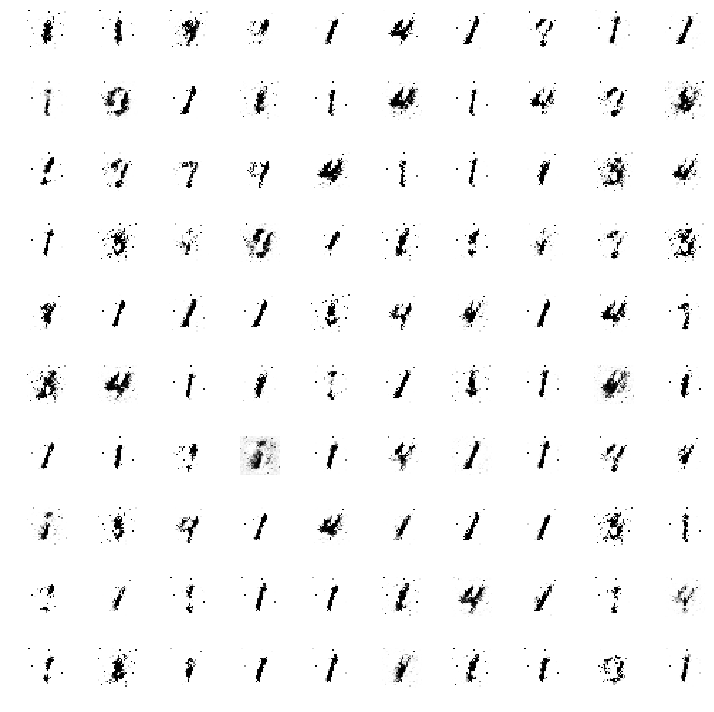

In [33]:
train(1, 128)